## Tritium Undersampling Experiment

#### Optimised HyperParameters:
#### Layer 1 Kernel Size: 100 samples (1000 ns)
#### Layer 2 Kernel Size: 60 samples (600 ns)
#### Layer 1 Filters: 64
#### Layer 2 Filters: 154
#### Stride: 4
#### Pool Size: 3
#### Learning Rate: 5.76249e-04
#### Batch Size: 323

### Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sn
import pandas as pd
import awkward as ak
import hist
from hist import Hist, axis
from sklearn.model_selection import train_test_split
from scipy.stats import binomtest
from sklearn.metrics import confusion_matrix

In [104]:
plt.rcParams['figure.figsize'] = [12, 8]
font = {'weight' : 'normal','size'   : 18}
plt.rc('font', **font)

# Load data from Parquet file and convert to strings
data_path = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [105]:
def normalise_array(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) / (np.max(sub_array) - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

def remove_array_offset(arr):
    # Normalise each sub-array individually and return as an awkward array for all times to start at zero.
    return ak.Array([
        (sub_array - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

# Apply normalisation to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

unnormalised_times = remove_array_offset(arr['times']) # Unnormalised times but shifted to start at zero (offset remove)

print(f"Lengths of first few subarrays in normalised_times: {ak.num(normalised_times, axis=1)[:10]}")
print(f"Example subarray from normalised_times: {normalised_times[0]}")
print(f"Example subarray from unnormalised_times: {unnormalised_times[3654]}")


# Print minimum and length for testing
# print(f"Minimum values of sub-arrays: {[sub_array.min() for sub_array in padded_times]}")
# print(f"Length of sub-array 200: {len(padded_times[200])}")

Lengths of first few subarrays in normalised_times: [1101, 932, 525, 640, 656, 651, 635, 829, 356, 1236]
Example subarray from normalised_times: [0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.996, 0.997, 0.998, 0.999, 1]
Example subarray from unnormalised_times: [0, 10, 20, 30, 40, 50, ..., 7.51e+03, 7.52e+03, 7.53e+03, 7.54e+03, 7.55e+03]


# Standardising Length of Data

In [106]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), mode='constant', constant_values=0) for sub_array in ak.to_list(array)]
        )
    )

print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))

times_lengths = ak.num(arr['times'], axis=1)
max_time_length = ak.max(times_lengths) # returns length of longest time series in dataset
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))
unnormalised_padded_times = np.array(pad_to_max_length(unnormalised_times, max_time_length))

sampling_interval_us = 0.01 # interval between consecutive samples in microseconds = 10 ns
time_us = [np.arange(len(wave)) * sampling_interval_us for wave in arr["times"]]
print(time_us[1036]) #TEST: the last element in this row should equal 18.3 µs

print(f"Length After Padding: {len(padded_times[0])}")
print(f"Length After Padding: {len(unnormalised_padded_times[3743])}")

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
[0.000e+00 1.000e-02 2.000e-02 ... 1.825e+01 1.826e+01 1.827e+01]
Length After Padding: 1828
Length After Padding: 1828


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

Now lets standardise the Sample data

In [107]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(arr['samples'][0])}")
print("Structure of 'times':", ak.type(arr['samples']))

samples_lengths = ak.num(arr['times'], axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")
# print(padded_samples[0][-200:])

print(f'\nLongest Waveform Class\n{arr["label"][max_samples_length_index]} (Cathode Event)')

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828

Longest Waveform Class
1 (Cathode Event)


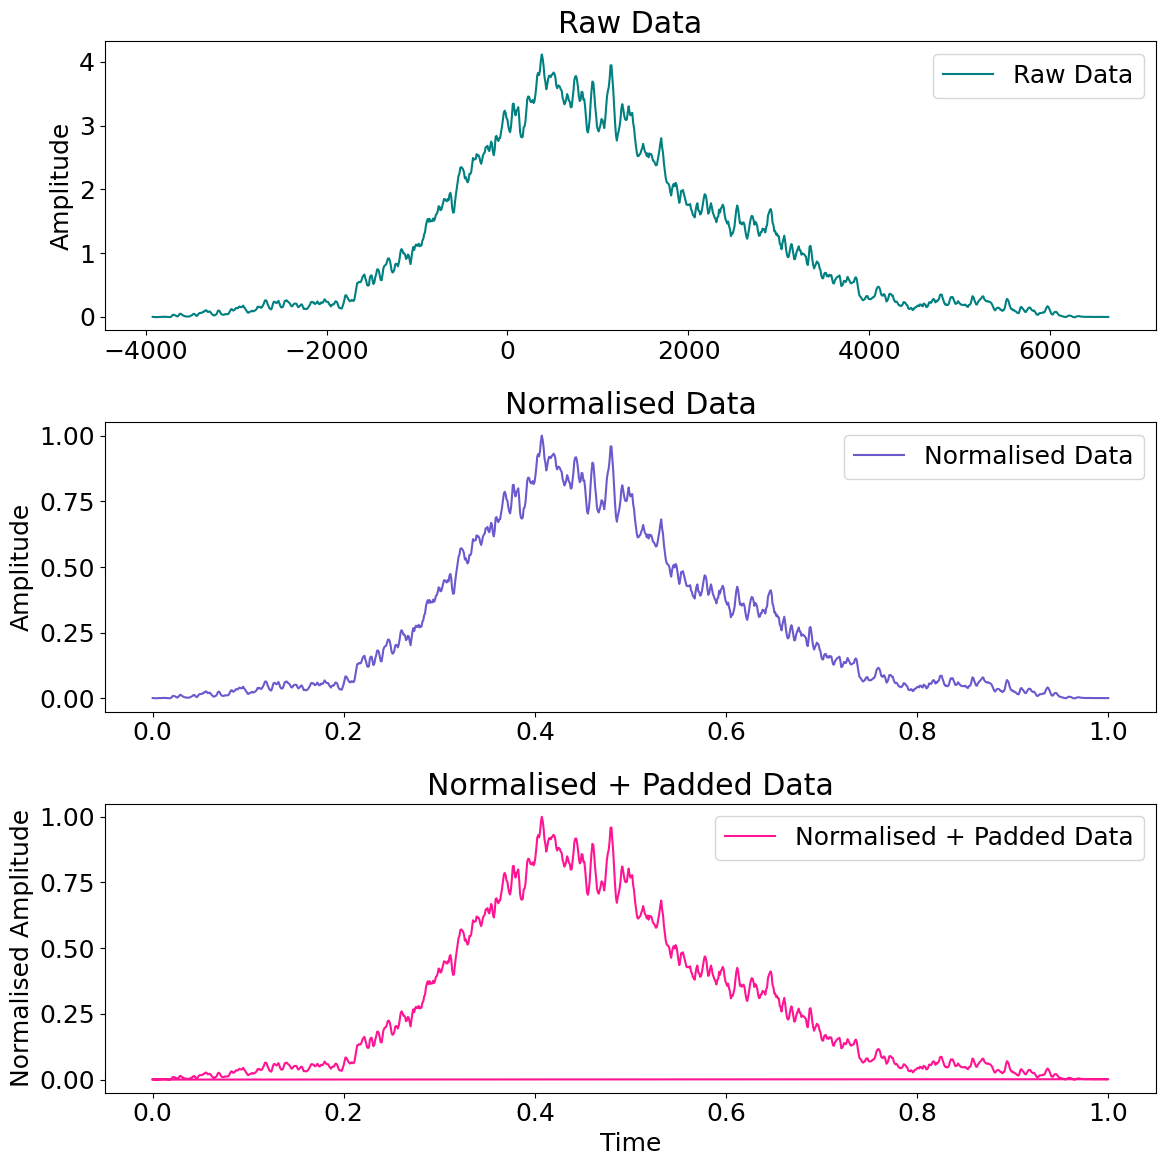

In [108]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))  # axs is an array of Axes

# Plot the first dataset in the first subplot
axs[0].plot(arr['times'][32], arr['samples'][32], label='Raw Data', color='teal')
axs[0].set_title("Raw Data")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot the second dataset in the first subplot
axs[1].plot(normalised_times[32], normalised_samples[32], label='Normalised Data', color='slateblue')
axs[1].set_title("Normalised Data")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

# Plot the third dataset in the second subplot
axs[2].plot(padded_times[32], padded_samples[32], label='Normalised + Padded Data', color='deeppink')
axs[2].set_title("Normalised + Padded Data")
axs[2].set_ylabel("Normalised Amplitude")
axs[2].legend()

# Add overall labels
plt.xlabel("Time")

# Adjust spacing between subplots for readability
plt.tight_layout()

# Show the plot
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/errorsinpaddingandnormalising.png')
plt.show()

# Creating the Training and Test Data (AwkwardArrays)

(7782, 2828)
(7782, 2828)


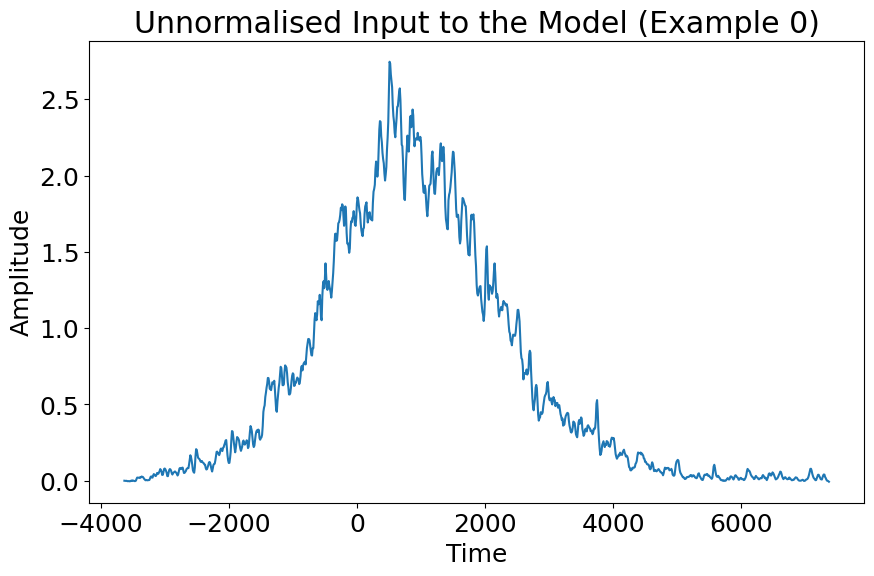

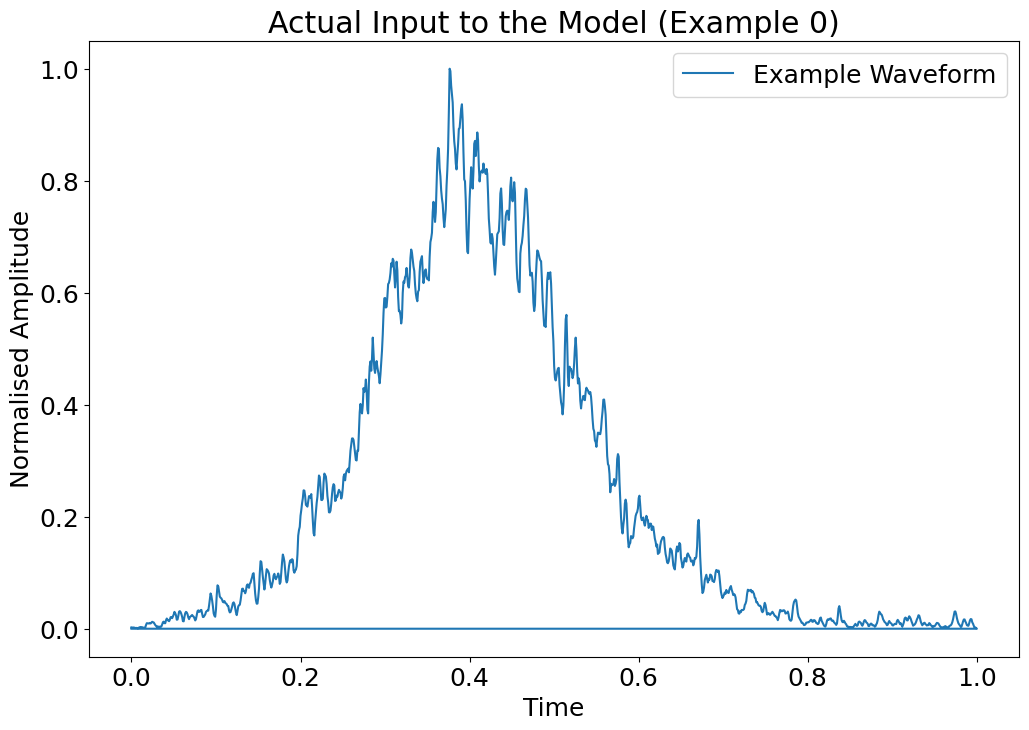

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Define padding length
padding_length = 500

# X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

# Add zero-padding on each side of the data (only along the time dimension for 2D data) Then reshape X_train_padded and X_test_padded to 3D
normalised_times_padded = np.pad(padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
unnormalised_times_padded = np.pad(unnormalised_padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
normalised_samples_padded = np.pad(padded_samples, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X = normalised_samples_padded
print(normalised_times_padded.shape)
print(X.shape)

time_steps = normalised_times_padded.shape[1]
example_index = 0
example_row = X[example_index]

# Split the row into time and samples
example_time = normalised_times_padded[example_index][500:-500]  # The time data of sample index {example_index}
example_samples = example_row[500:-500]  # The sample data of sample index {example_index}

plt.figure(figsize=(10, 6))
plt.plot(arr['times'][0], arr['samples'][0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(f"Unnormalised Input to the Model (Example {example_index})")

plt.show()
plt.plot(example_time, example_samples, label="Example Waveform")
plt.xlabel("Time")
plt.ylabel("Normalised Amplitude")
plt.title(f"Actual Input to the Model (Example {example_index})")
plt.legend()
# plt.grid(True)
plt.show()

# S2 Area Spectrum before Tritium Undersampling

305.75293803418805


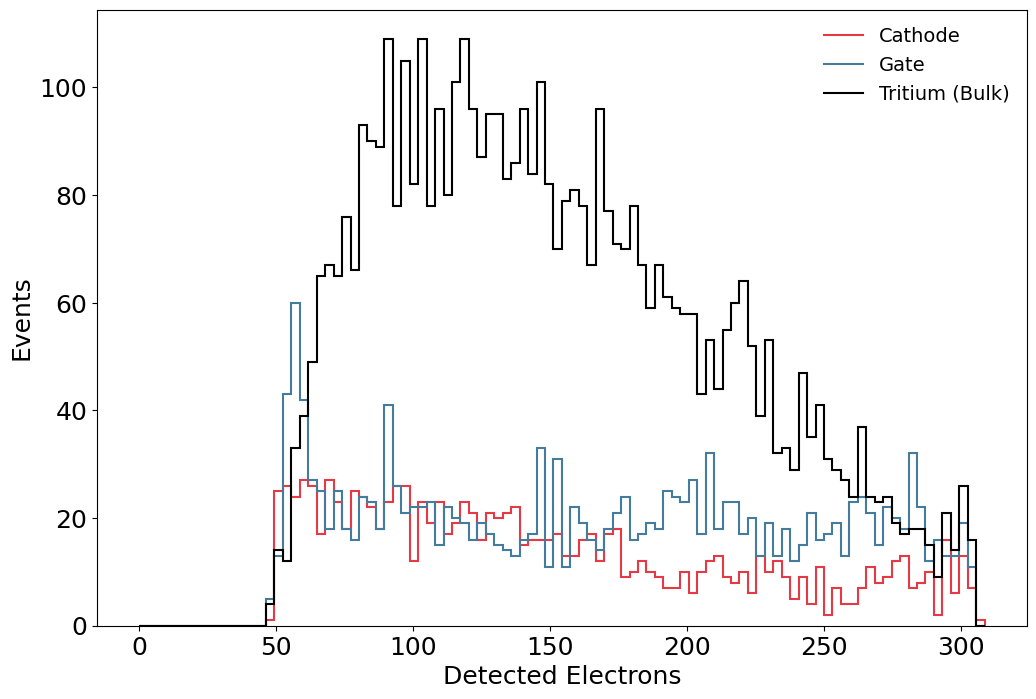

In [110]:
areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
cathode_hist.fill(cathode_events)
cathode_hist.plot(color='#E63946',density=False,yerr=False,label='Cathode')

gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
gate_hist.fill(gate_events)
gate_hist.plot(color='#457B9D',density=False,yerr=False,label='Gate')

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
tritium_hist.fill(tritium_events)
tritium_hist.plot(color='black',density=False,yerr=False,label='Tritium (Bulk)')


ax.set(xlabel='Detected Electrons',ylabel='Events')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/Pulse_Spectrum.png', dpi=1800)
plt.show()

In [111]:
bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
# print(bin_edges[-2])

# Retrieve and adjust counts for each histogram to transform counts data into events/electron
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(f'Total Number of Examples of Each Event Type:\n Cathode {int(cathode_hist.view().sum())} \n Gate {int(gate_hist.view().sum())} \n Tritium {int(tritium_hist.view().sum())}')
# print(tritium_counts[-1])
# print(gate_counts[-1])
# print(cathode_counts[-1])

Total Number of Examples of Each Event Type:
 Cathode 1189 
 Gate 1711 
 Tritium 4882


# Weighting the S2 Area Spectrum

Maximum Areas: 
 Cathode 17886.546875 
 Gate 17847.5546875 
 Tritum 17881.375 
 Overall Dataset 17886.546875
Total Area under Gate Histogram 13.411785247523326
Total Area under Cathode Histogram 10.274164346048565
Total Area under Tritium Histogram 37.54691093085141


/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_74411/2077088347.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_74411/2077088347.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_74411/2077088347.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_74411/2077088347.py:50: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipyke

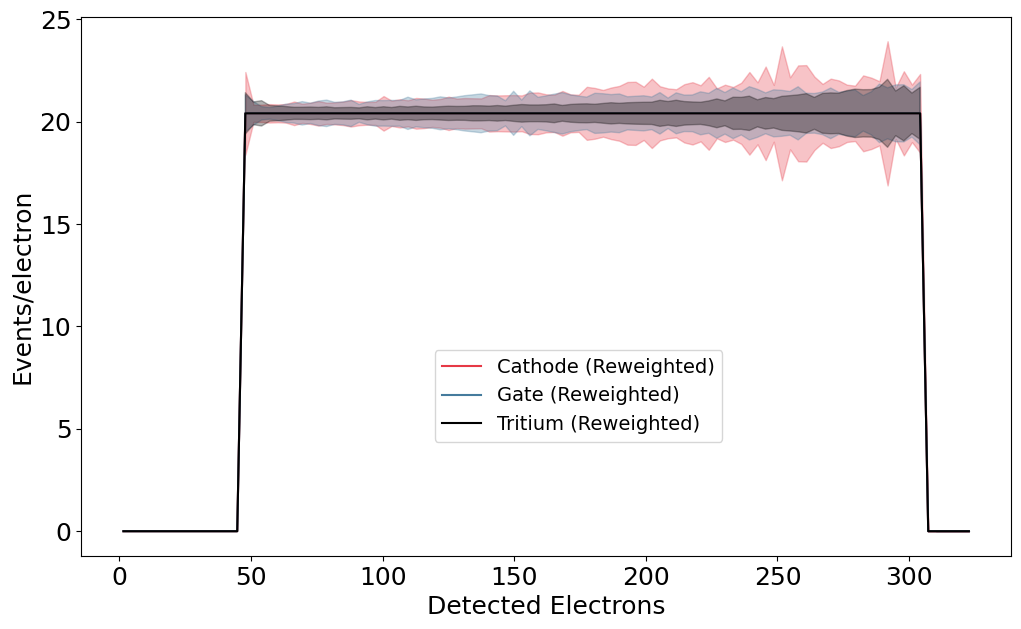

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'Maximum Areas: \n Cathode {max_cathode_area} \n Gate {max_gate_area} \n Tritum {max_tritium_area} \n Overall Dataset {max_area}')

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 

print(f'Total Area under Gate Histogram {gate_counts.sum()}') # total area under the histogram (integral of histogram)
print(f'Total Area under Cathode Histogram {cathode_counts.sum()}') # total area under the histogram (integral of histogram)
print(f'Total Area under Tritium Histogram {tritium_counts.sum()}') # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()]) # average integral (area) of each histgoram to be used as reweighting benchmark

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] > cathode_counts[-1] else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

# print(gate_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /70 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/70 # * (average_counts / cathode_counts.sum())

# PADDING: Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Plot reweighted data with translucent error bands

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='#E63946', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='#E63946', alpha=0.3
)

# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='#457B9D', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='#457B9D', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='black', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='black', alpha=0.3
)


ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0.7,0.4),loc='upper right',frameon=True,fontsize=14) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_undersampling_weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [113]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights) # check if values are defined (finite), 0 if not.

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)

#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [114]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Optional Code: Normalising the Weights Array

In [115]:
num_events = len(arr['weights'])
total_weight = ak.sum(arr['weights'])
mean_weight = total_weight / num_events
weights_mean_one = arr['weights'] / mean_weight # rescale all weights to have a mean of 1.
arr = ak.with_field(arr, weights_mean_one, 'weights_normalised')
print(arr['weights_normalised'])

[4.23, 0.18, 1.1, 1.1, 1.1, 1.1, 1.1, ..., 6.14, 6.14, 6.14, 6.14, 6.14, 6.14]


In [116]:
seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Smaller kernels in early layers capture local, fine-grained features (like edges or small peaks in your waveforms), while larger kernels in deeper layers can aggregate these to detect more complex patterns.
Smaller kernels in early layers (where the input has higher resolution/more time steps) also help to reduce computational load. Lastly, Even with small kernels, deeper layers naturally have a smaller effective receptive field due to the cumulative effect of convolutions through the network hence making it natural for deeper conv layers to have smaller kernels.

# Under-sampling of Tritium Examples Experiment

In [145]:
weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalised'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalised_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']
radii = ak.to_numpy(arr['r'])

# Get counts for each class
cathode_indices = np.where(labels == 0)[0]
gate_indices = np.where(labels == 1)[0]
tritium_indices = np.where(labels == 2)[0]
    
print(f"\n===Original Class Distribution===")
print(f"Cathode: {len(cathode_indices)}")
print(f"Gate: {len(gate_indices)}")
print(f"Tritium: {len(tritium_indices)}")

target_count = int(((gate_hist.view().sum()) + (cathode_hist.view().sum())) / 2)

print(f'\nAverage of Gate and Cathode Occurences in Original Array: {target_count}')

tritium_occurences = normalised_samples_padded[np.where(labels == 2)[0]]
print(f'Total Number of Tritium Occurences in Original Array: {len(tritium_occurences)}')

sampled_tritium_indices = np.random.choice(np.where(arr['label'] == 2)[0], target_count, replace=False)

# Now we need to go through original array, and create a new array that selects tritium events only from the sampled indices.
# If we take ALL cathode and gate occurences (and append their corresponding indices to a list) and add the undersampled ONLY tritium occurences, we will have a new array
# that is a near duplicate of original 'arr' but one that is now balanced.
sampled_indices = np.concatenate((cathode_indices, gate_indices, sampled_tritium_indices))
sampled_indices = np.sort(sampled_indices)

# Create a new array that only contains the sampled indices
sampled_arr = arr[sampled_indices]

sampled_tritium_occurences = sampled_arr[np.where(sampled_arr['label'] == 2)[0]]
print(f'Length of Sampled Tritium Indices: {len(sampled_tritium_occurences)}')

print(f'\nTotal Number of Training Examples in Tritium Under-sampled Array \n{int(gate_hist.view().sum() + cathode_hist.view().sum() + len(sampled_tritium_occurences))}')

sampled_X = X[sampled_indices]
sampled_labels = labels[sampled_indices]
sampled_normalised_area = normalised_area[sampled_indices]
sampled_normalised_weights_np = normalised_weights_np[sampled_indices]
sampled_normalised_times = normalised_times[sampled_indices]
time_us_np = np.array(time_us, dtype=object)
sampled_time_us = time_us_np[sampled_indices]
sampled_normalised_samples = normalised_samples[sampled_indices]
sampled_radii = radii[sampled_indices]

print(len(sampled_X))

# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: NORMALISED WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test, \
normalised_times_train, normalised_times_test, times_us_train, times_us_test, \
normalised_samples_train, normalised_samples_test, r_train, r_test = train_test_split(
    sampled_X, sampled_labels, sampled_normalised_area, sampled_normalised_weights_np, sampled_normalised_times, sampled_time_us, sampled_normalised_samples, sampled_radii, 
    test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test)
print("Shape of y_train:", y_train.shape)

y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

X_train_padded = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # adding a channels dimension (greyscale of 1) to enable seamless input into CNN
X_test_padded = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train_padded.shape[0] + X_test_padded.shape[0])


7782

===Original Class Distribution===
Cathode: 1189
Gate: 1711
Tritium: 4882

Average of Gate and Cathode Occurences in Original Array: 1450
Total Number of Tritium Occurences in Original Array: 4882
Length of Sampled Tritium Indices: 1450

Total Number of Training Examples in Tritium Under-sampled Array 
4350
4350
Length of X_train: 3262
Length of y_train: 3262
Length of weights_train: 3262
Shape of weights_train: (3262,)
Shape of X_train: (3262, 2828)
Shape of y_train: (3262,)
4350


In [118]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.01,      # Minimum change in loss to qualify as an improvement
    patience=3,          # Stop training after 3 epochs of no significant improvement
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restore the weights from the best epoch
)

convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=100, activation='relu', padding='same', input_shape=(X_train_padded.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=60, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers. 2D pooled feauture map flattened to 1D vector to input into dense outer layers.
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
optimizer = legacy.Adam(learning_rate=5.762e-4)
convoNN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 64 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2) specifies a pooling window which means the layer will take the max value from every 2-linear-unit-wide region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
history = convoNN.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=5, batch_size=323, validation_split=0.2, verbose=0)

## Model Evaluation on Test Data

34/34 [==============================] - 3s 82ms/step - loss: 0.3380 - accuracy: 0.8631


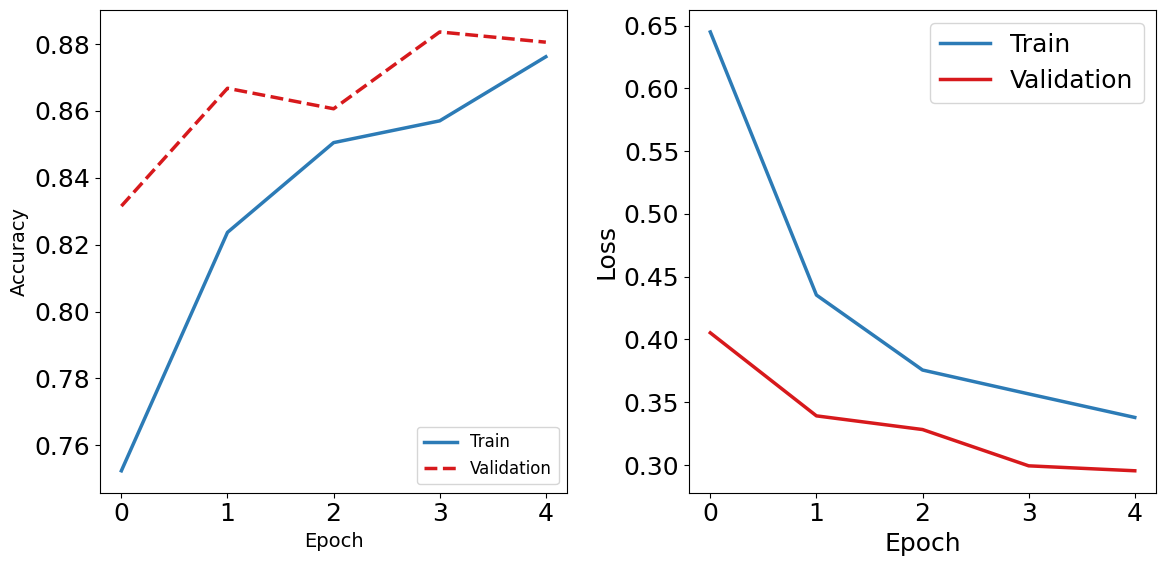

In [130]:
convoNN.evaluate(X_test_padded, y_test, verbose=1) # tf.model.evaluate() will return a list (or tuple) with two numbers: 
# The first number is the loss computed on the test set (using sparse categorical crossentropy).
# The second number is the accuracy computed on the test set.


# Testing for overfitting with better colors
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy with improved colors
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='#2C7BB6', linewidth=2.5, label='Train')
plt.plot(history.history['val_accuracy'], color='#D7191C', linewidth=2.5, linestyle='--', label='Validation')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Plot training & validation loss with improved colors
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='#2C7BB6', linewidth=2.5, label='Train')
plt.plot(history.history['val_loss'], color='#D7191C', linewidth=2.5, label='Validation')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(loc='upper right', fontsize=18)

plt.tight_layout()
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_undersampling_training_validation_loss.png', dpi=1800)
plt.show()

# Visualising the Model Classification Effectiveness: The Probability Distribution

34/34 [==============================] - 3s 80ms/step


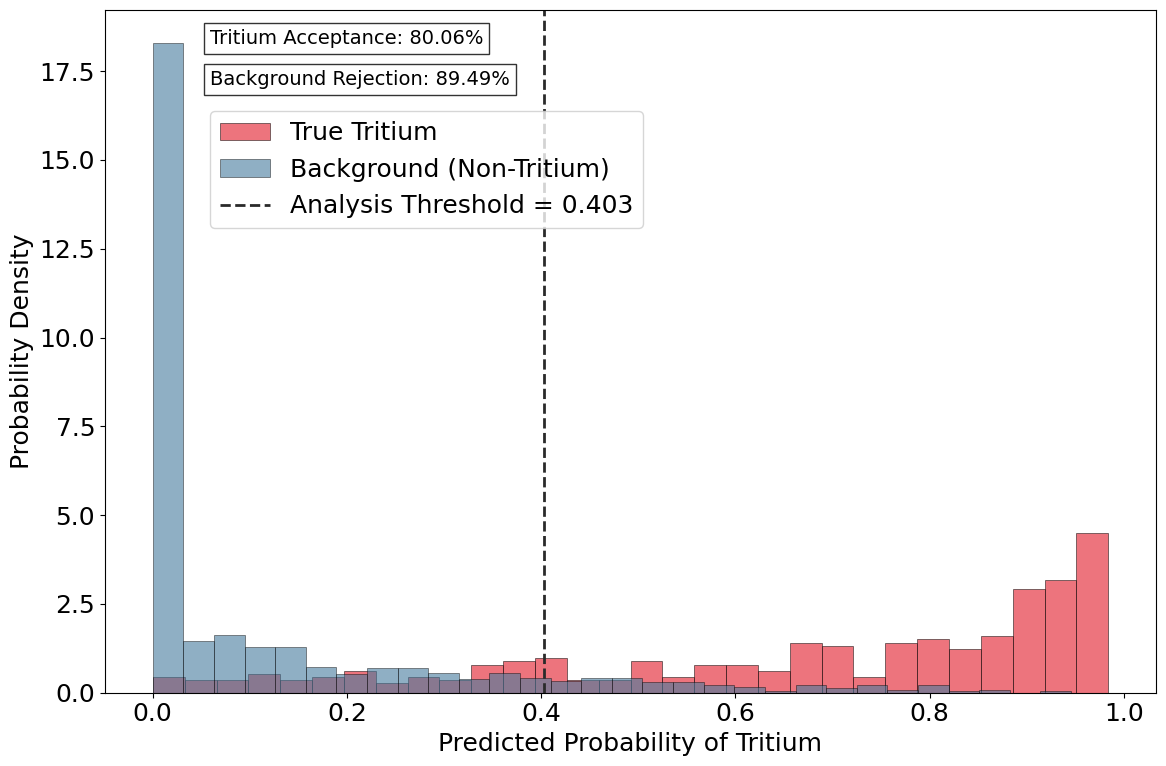

In [143]:
# Step 1: Get predicted probabilities for each class
y_pred_proba = convoNN.predict(X_test_padded)
predicted_classes = np.argmax(y_pred_proba, axis=1)

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities

# Separate true Tritium events from non-Tritium events
true_tritium_mask = (y_test == 2)  # actual tritium events
non_tritium_mask = (y_test != 2)  # non-tritium(background) events

# Find threshold at 20th percentile of true Tritium probabilities
threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot normalized histograms with better styling
plt.figure(figsize=(12, 8))

# Histogram for actual Tritium events - normalized with density=True
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.7, 
         color='#E63946', label='True Tritium', density=True,
         edgecolor='black', linewidth=0.5)

# Histogram for non-Tritium events - also normalized
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.6, 
         color='#457B9D', label='Background (Non-Tritium)', density=True,
         edgecolor='black', linewidth=0.5)

# Add threshold line with improved styling
plt.axvline(x=threshold, color='#2A2A2A', linestyle='--', linewidth=2,
           label=f'Analysis Threshold = {threshold:.3f}')

# Calculate acceptance and rejection rates for display in the legend
tritium_acceptance = np.mean(bulk_proba[true_tritium_mask] >= threshold)
background_rejection = np.mean(bulk_proba[non_tritium_mask] < threshold)

# Add statistics to plot
plt.text(0.1, 0.95, f"Tritium Acceptance: {tritium_acceptance:.2%}", 
         transform=plt.gca().transAxes, fontsize=14, 
         bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.89, f"Background Rejection: {background_rejection:.2%}", 
         transform=plt.gca().transAxes, fontsize=14,
         bbox=dict(facecolor='white', alpha=0.8))

# Better styling for labels and legend
plt.xlabel('Predicted Probability of Tritium', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=[0.1, 0.68], fontsize=18)
# Add tight layout for better spacing
plt.tight_layout()

plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_undersampling_probability_histogram.png', dpi=1800)
plt.show()

## Figure 7 (LUX-LOWMASS) Production
### We use Clopper-Pearson Confidence Intervals in our Error Propagation

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.403


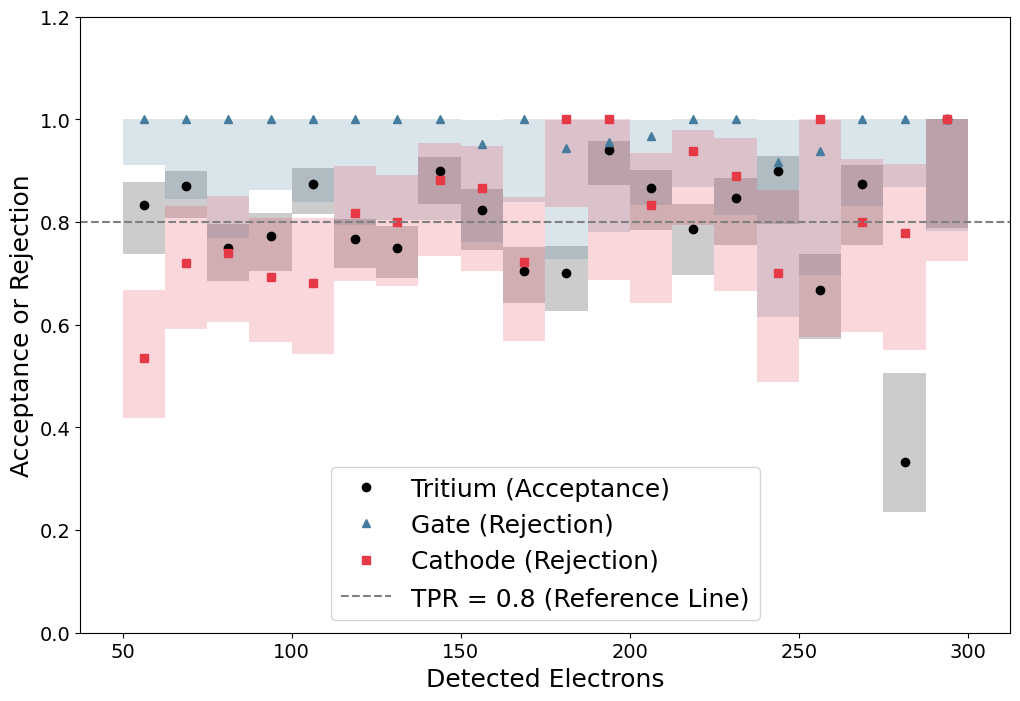

In [121]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(50, 300, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalise by true Tritium count

            ci = binomtest(accepted_tritium, total_tritium).proportion_ci(confidence_level=0.95)
            lower_error = (accepted_tritium / total_tritium) - ci.low
            upper_error = ci.high - (accepted_tritium / total_tritium)
            tritium_error.append((lower_error, upper_error)) # append confidence interval tuples to tritium_error array.
            # error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            # tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin
            tritium_error.append((0, 0))

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count

            ci = binomtest(rejected_gate, total_gate).proportion_ci(confidence_level=0.95)
            lower_error = (rejected_gate / total_gate) - ci.low
            upper_error = ci.high - (rejected_gate / total_gate)
            gate_error.append((lower_error, upper_error))
            # error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            # gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))
            gate_error.append((0, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count

            ci = binomtest(rejected_cathode, total_cathode).proportion_ci(confidence_level=0.95)
            lower_error = (rejected_cathode / total_cathode) - ci.low
            upper_error = ci.high - (rejected_cathode / total_cathode)
            cathode_error.append((lower_error, upper_error))
            # error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            # cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))
            cathode_error.append((0, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot Tritium acceptance with filled error bars
for x, y, (lower_error, upper_error) in zip(tritium_x, tritium_y, tritium_error):
    lower_bound = y - (lower_error)*0.3
    upper_bound = y + (upper_error) *0.3
    plt.plot(x, y, 'o', color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection with filled error bars
for x, y, (lower_error, upper_error) in zip(gate_x, gate_y, gate_error):
    lower_bound = y - lower_error
    upper_bound = y + upper_error
    plt.plot(x, y, '^', color='#457B9D', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='#457B9D', alpha=0.2, linewidth=0)

# Plot Cathode rejection with filled error bars
for x, y, (lower_error, upper_error) in zip(cathode_x, cathode_y, cathode_error):
    lower_bound = y - (lower_error) * 0.6
    upper_bound = y + (upper_error) * 0.7
    plt.plot(x, y, 's', color='#E63946', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='#E63946', alpha=0.2, linewidth=0)

# Add reference line and other plot elements
plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons", fontsize=18)
plt.ylabel("Acceptance or Rejection", fontsize=18)
plt.legend(loc='lower center', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title("Acceptance and Rejection Rates with Confidence Intervals")
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/Undersampled_HE_Fig7.png', dpi=1800)
plt.show()

# Confusion Matrix

34/34 [==============================] - 3s 86ms/step


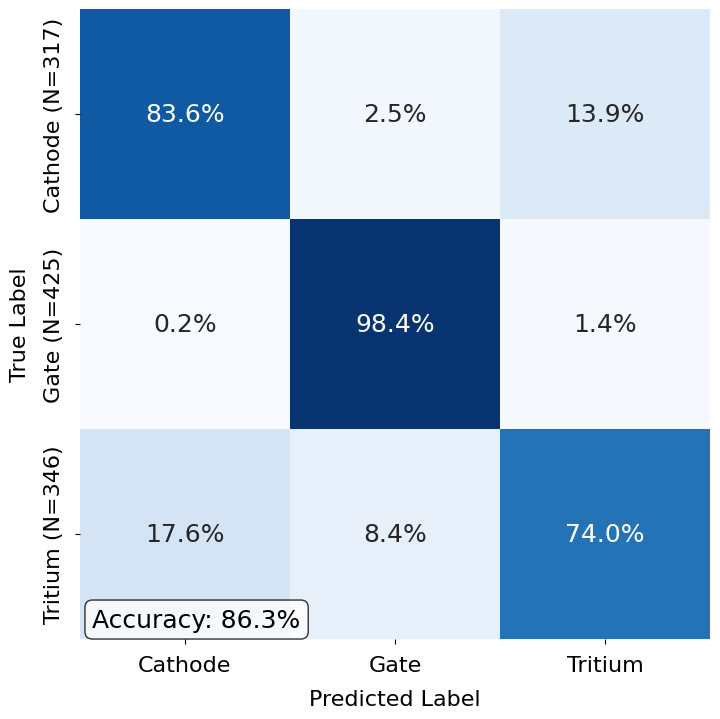

In [132]:
def plot_normalised_confusion_matrix(y_true, y_pred, class_names=['Cathode', 'Gate', 'Tritium']):
    """
    Plot a normalised confusion matrix showing percentages of each true class.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    class_names : list
        Names of the classes
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a figure with custom size
    plt.figure(figsize=(12, 8))
    
    # Calculate the row totals (total per class)
    row_totals = cm.sum(axis=1)
    
    # Create percentage matrix for the heatmap colors
    cm_percent = np.zeros_like(cm, dtype=float)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cm_percent[i, j] = (cm[i, j] / row_totals[i]) * 100 if row_totals[i] > 0 else 0
    
    # Create annotation strings with percentages
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / row_totals[i]) * 100 if row_totals[i] > 0 else 0
            annot[i, j] = f"{percentage:.1f}%"
    
    # Plot the heatmap with percentage values (no colorbar)
    ax = sn.heatmap(cm_percent, annot=annot, fmt='s', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   vmin=0, vmax=100, square=True, cbar=False)
    
    # Improve the appearance
    ax.set_xlabel('Predicted Label', fontsize=16, labelpad=10)
    ax.set_ylabel('True Label', fontsize=16, labelpad=10)
    
    # Set fontsize for tick labels and move them away from the plot
    ax.tick_params(axis='both', which='major', labelsize=16, pad=8)
    
    # Add class totals to the tick labels with enough padding
    new_labels = [f"{name} (N={total})" for name, total in zip(class_names, row_totals)]
    ax.set_yticklabels(new_labels, fontsize=16, rotation=90)
    ax.set_xticklabels(class_names, fontsize=16)
    
    # Add a text box with overall accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
    plt.text(0.02, 0.02, f"Accuracy: {accuracy:.1f}%",
             transform=ax.transAxes, fontsize=18,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add padding around the plot
    plt.tight_layout(pad=2.0)
    
    return ax

y_pred = np.argmax(convoNN.predict(X_test_padded), axis=1)

# Plot the confusion matrix
plot_normalised_confusion_matrix(y_test_np, y_pred)
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/Undersampled_confusion_matrix.png', dpi=1800)
plt.show()

# Undersampled Area Histogram

/Users/laith_mohajer/Documents/GitHub/MSCIProject/newenv/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/Users/laith_mohajer/Documents/GitHub/MSCIProject/newenv/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/Users/laith_mohajer/Documents/GitHub/MSCIProject/newenv/lib/python3.11/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


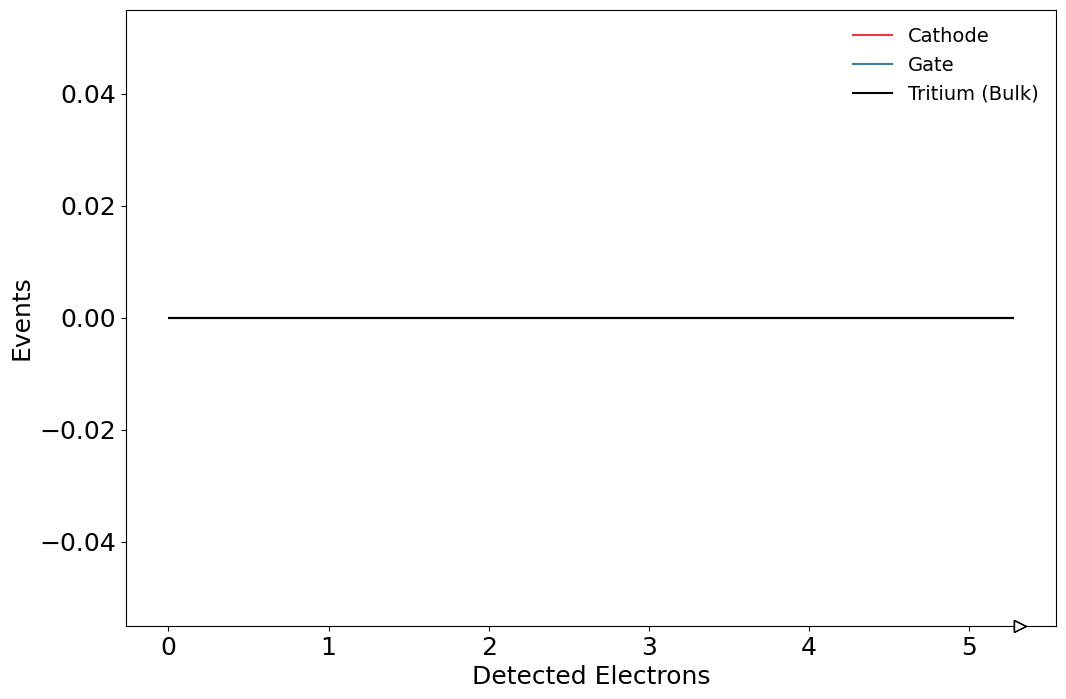

In [146]:
usampled_fig, usampled_ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum

usampled_cathode_events = sampled_arr[(sampled_arr['label'] == 0)].area / electron_size
usampled_gate_events = sampled_arr[(sampled_arr['label'] == 1)].area / electron_size
usampled_tritium_events = sampled_arr[(sampled_arr['label'] == 2)].area / electron_size

usampled_cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
usampled_cathode_hist.fill(usampled_cathode_events)
usampled_cathode_hist.plot(color='#E63946',density=False,yerr=False,label='Cathode')

usampled_gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
usampled_gate_hist.fill(usampled_gate_events)
usampled_gate_hist.plot(color='#457B9D',density=False,yerr=False,label='Gate')

usampled_tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
usampled_tritium_hist.fill(usampled_tritium_events)
usampled_tritium_hist.plot(color='black',density=False,yerr=False,label='Tritium (Bulk)')


usampled_ax.set(xlabel='Detected Electrons',ylabel='Events')
usampled_ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/Undersampled_Pulse_Spectrum.png', dpi=1800)
plt.show()

# Visualising the Inputs to the Model

2828
(3262,)
2828
1828
2328


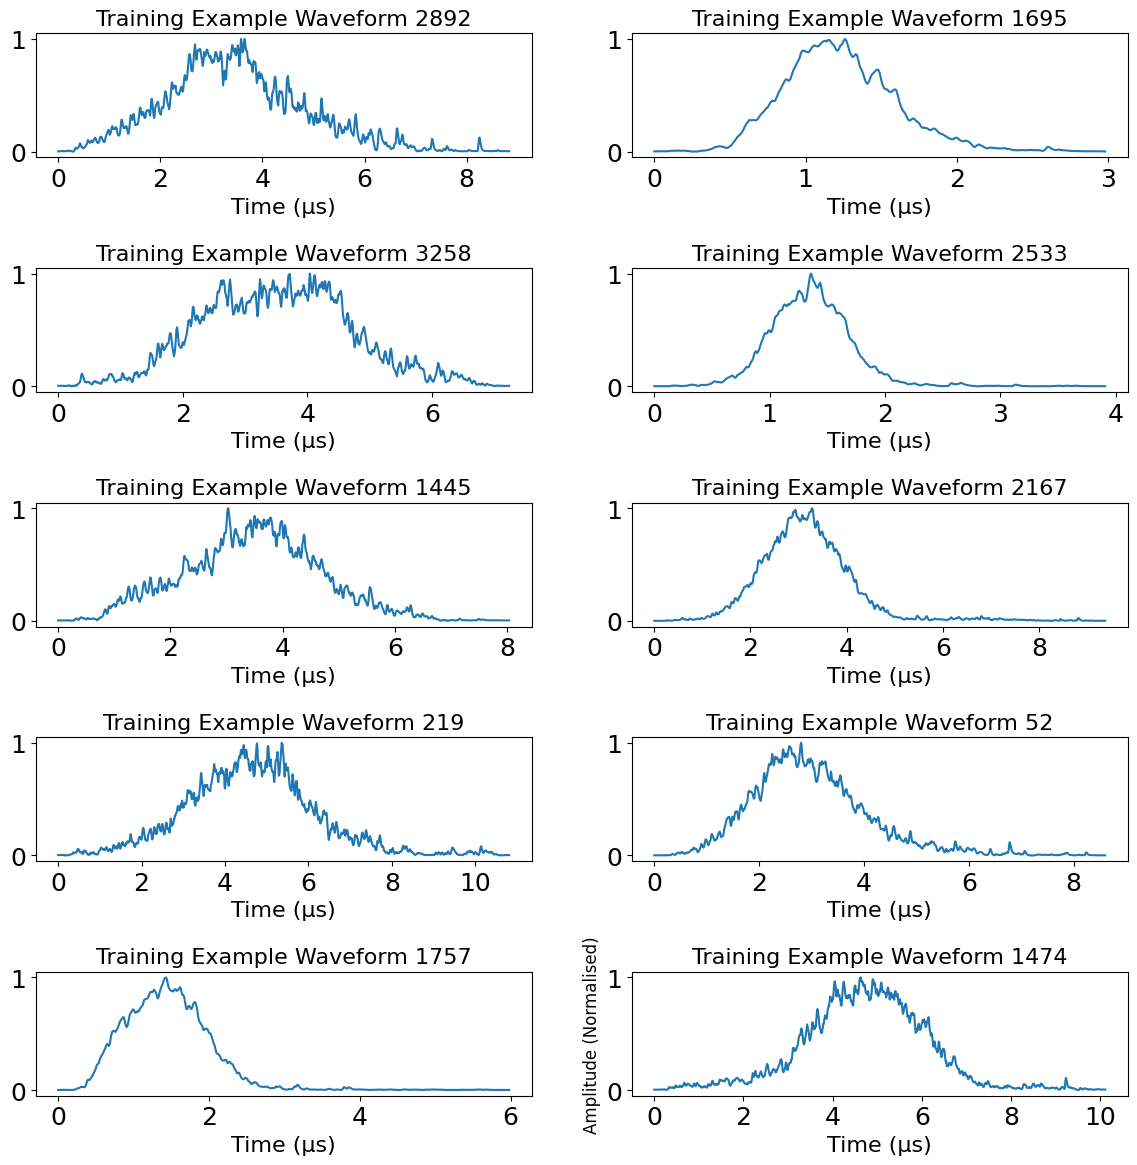

In [124]:
from tensorflow.keras.models import Model
print(X_train_padded.shape[1])
print(y_train.shape)

# Select every 10^2-th waveform
step = 100  # Step size for selection
waveforms_to_plot = X_train_padded[::step]

num_samples = X_train_padded.shape[1]
print(num_samples)

# Calculate sample length before padding
original_time_sample_length = (num_samples - (2 * padding_length)) #// 2 # floor division (round down to nearest integer)
print(original_time_sample_length)
print(original_time_sample_length + (padding_length))

# Visualise the first 10 padded training examples
# Generate 10 random indices to plot 10 random examples
random_indices = np.random.randint(0, len(normalised_samples_train), size=10)

plt.figure(figsize=(12,12))
for idx, i in enumerate(random_indices):  # Iterate through the random indices
    plt.subplot(5, 2, idx + 1)
    plt.plot(times_us_train[i], normalised_samples_train[i])
    plt.title(f"Training Example Waveform {i}", fontsize=16)
    plt.xlabel("Time (µs)", fontsize = 16)
    # plt.ylabel("Amplitude (Normalised)")

plt.ylabel("Amplitude (Normalised)", fontsize=12)
plt.tight_layout()
plt.show()

# Visualising the Feature Maps (Detected Features by the Filters)

To extract numerical feature maps from these layers, we need to create an intermediate model ('feauture_model') and pass real input data through it.
'feauture_model' is a new sub-model that takes the same input as convoNN but outputs intermediate activations (feature maps) from the layers specified in layer_outputs.

In [125]:
sample_index = 32

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_74411/2910614908.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif y_test[sample_index == 2]:


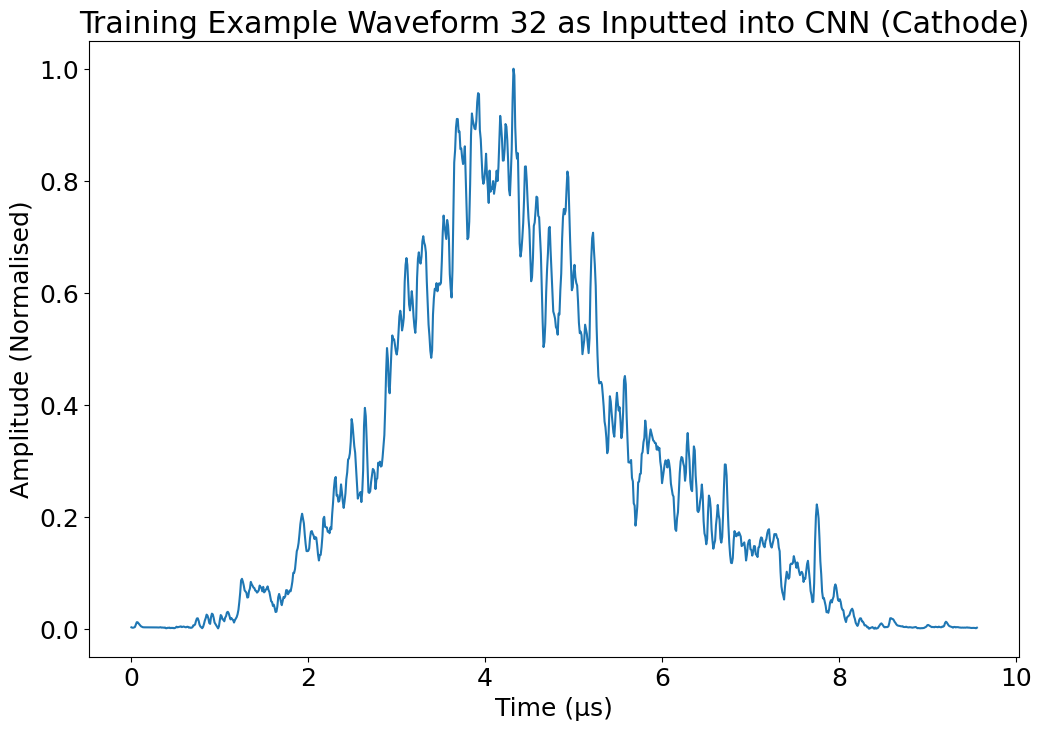

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2828, 64)          6464      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1414, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1414, 64)          245824    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 707, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 45248)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [126]:
if y_test[sample_index] == 1:
    class_name = "Gate"
elif y_test[sample_index == 2]:
    class_name = "Tritium"
else:
    class_name = "Cathode"
plt.plot(times_us_train[sample_index], normalised_samples_train[sample_index]) # X_train padded is just the reshaped version to change the 2D array into 3D format - the format required for CNN input
# plt.scatter(X_train[0][:2828], X_train[0][2828:])
#plt.plot(arr['times'][0], arr['samples'][0])
# plt.plot(X[0][:1828], X_combined[0][1828:])
plt.ylabel("Amplitude (Normalised)")
plt.xlabel("Time (µs)")
plt.title(f'Training Example Waveform 32 as Inputted into CNN ({class_name})')
plt.show()

print(convoNN.summary())

In [127]:
from tensorflow.keras.models import Model
import math

# Specify the layers from which you want to extract features (e.g., the outputs of the Conv1D layers)
layer_outputs = [layer.output for layer in convoNN.layers if isinstance(layer, keras.layers.Conv1D)]
feature_model = Model(inputs=convoNN.input, outputs=layer_outputs) # Creating the intermediate model. Same input as CNN but outputs the activations of certain layers

sample_input = X_test_padded[sample_index:sample_index+1]  # Selecting a specific example
# When you use slicing — even if the slice only contains one element — Python returns a subarray that retains the original dimensions. 
# So X_test_padded[32:33] gives you an array with shape (1, time_steps, channels). The batch dimension is preserved.
# Most deep learning frameworks, including Keras, expect the input data to have a specific shape that includes the batch dimension. 
# Typically, a model is defined to accept inputs of shape (batch_size, time_steps, channels) for a 1D convolution. 
# Even if predicting on a single sample, the model still expects a three-dimensional tensor:
# With the Batch Dimension: The input shape is (1, time_steps, channels), where 1 represents one sample in the batch. Keeps the tensor 3D - suitable for CNN input.

feature_maps = feature_model.predict(sample_input) # This variable is intended to hold the outputs (also called activations or feature maps) 
# produced by selected layers when an input is passed through the intermediate model.

1/1 [==============================] - 0s 33ms/step


/Users/laith_mohajer/Documents/GitHub/MSCIProject/newenv/lib/python3.11/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(



Cathode event - Area: Small, Radius: Close (Sample index 1035)
1/1 [==============================] - 0s 58ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


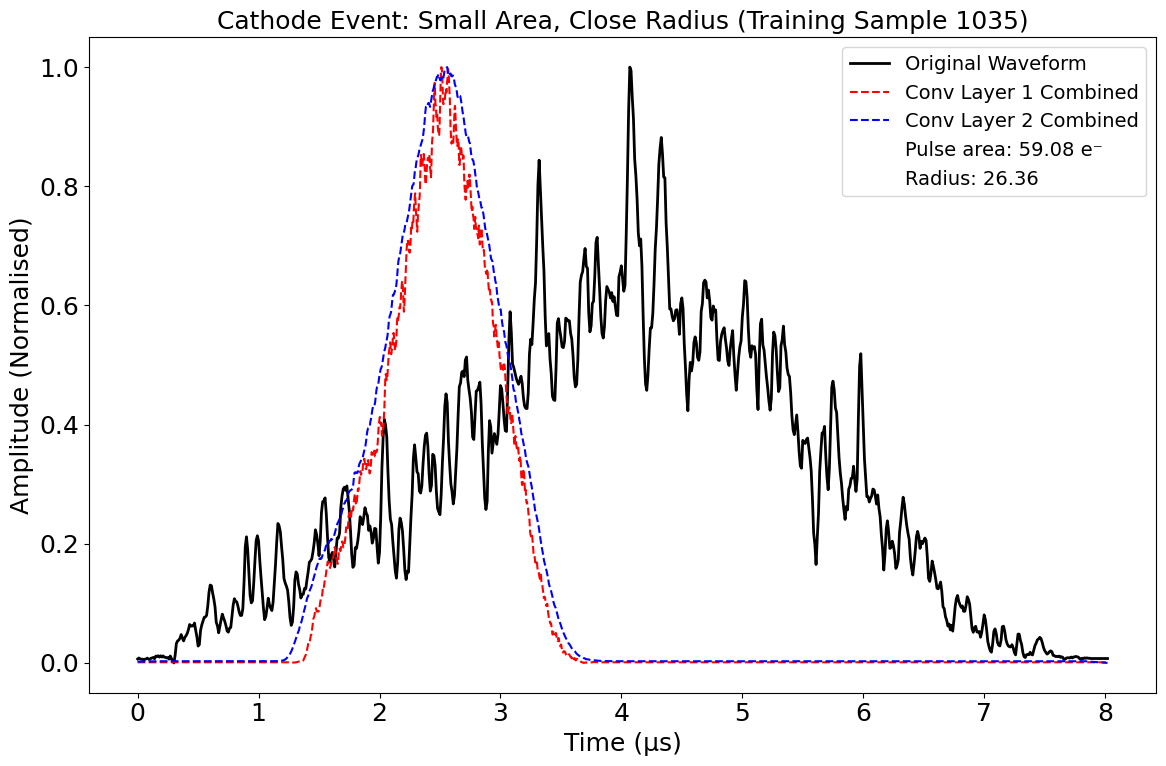


Cathode event - Area: Small, Radius: Medium (Sample index 103)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


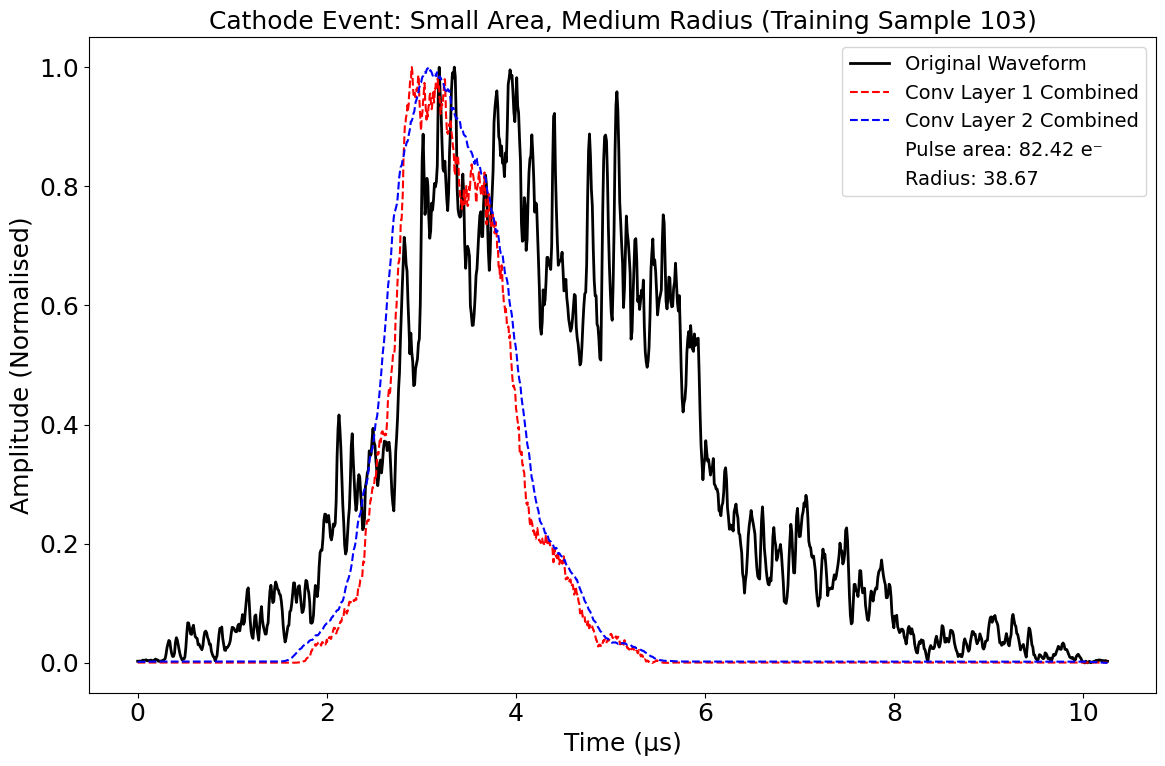


Cathode event - Area: Small, Radius: Far (Sample index 2657)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


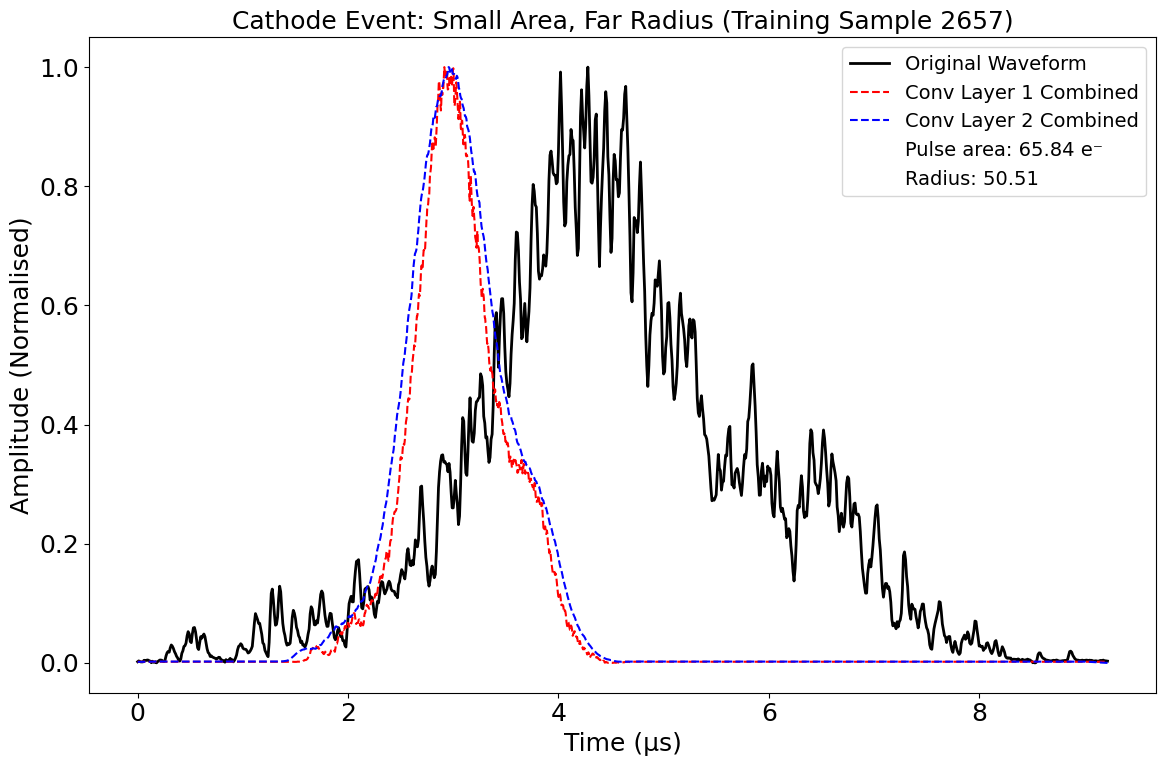


Cathode event - Area: Medium, Radius: Close (Sample index 892)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


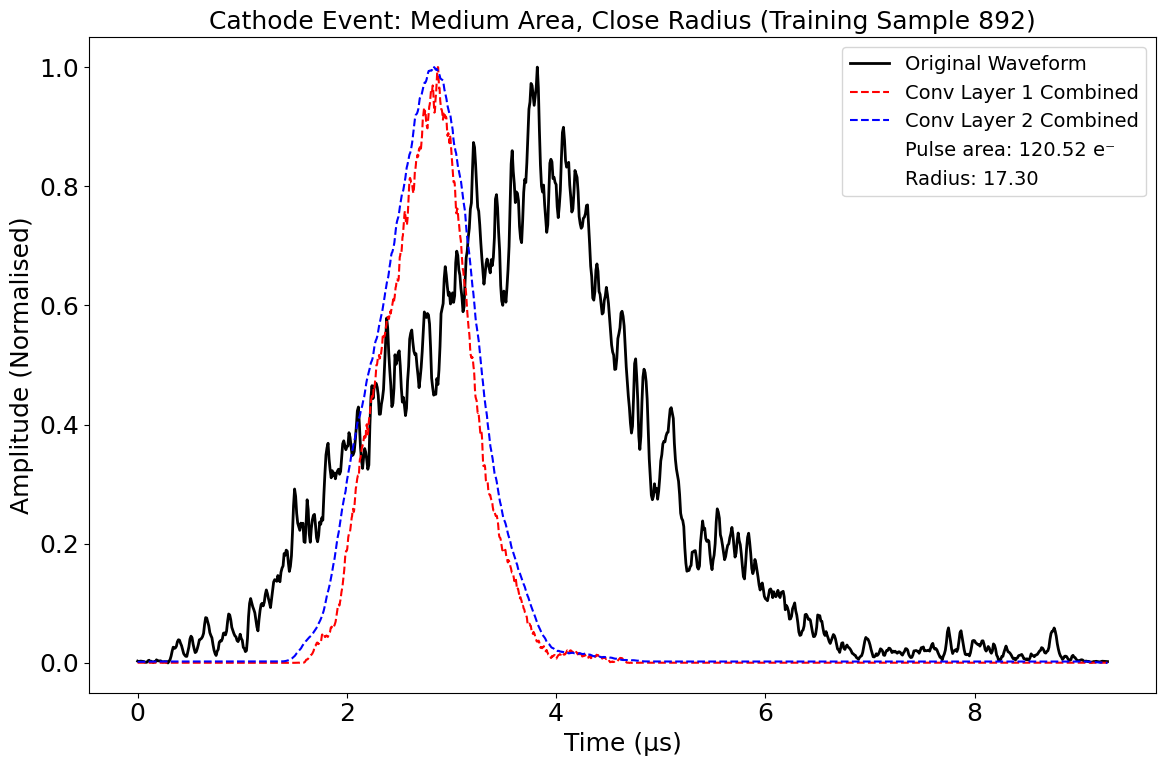


Cathode event - Area: Medium, Radius: Medium (Sample index 1573)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


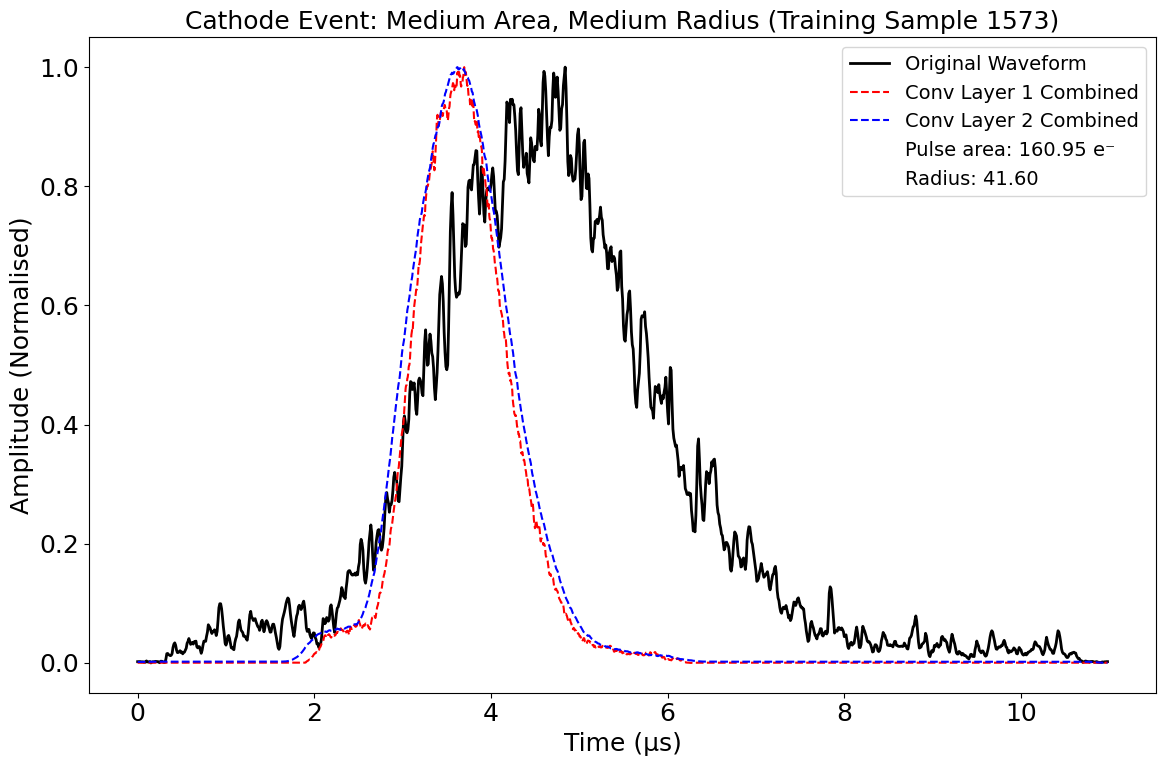


Cathode event - Area: Medium, Radius: Far (Sample index 2086)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


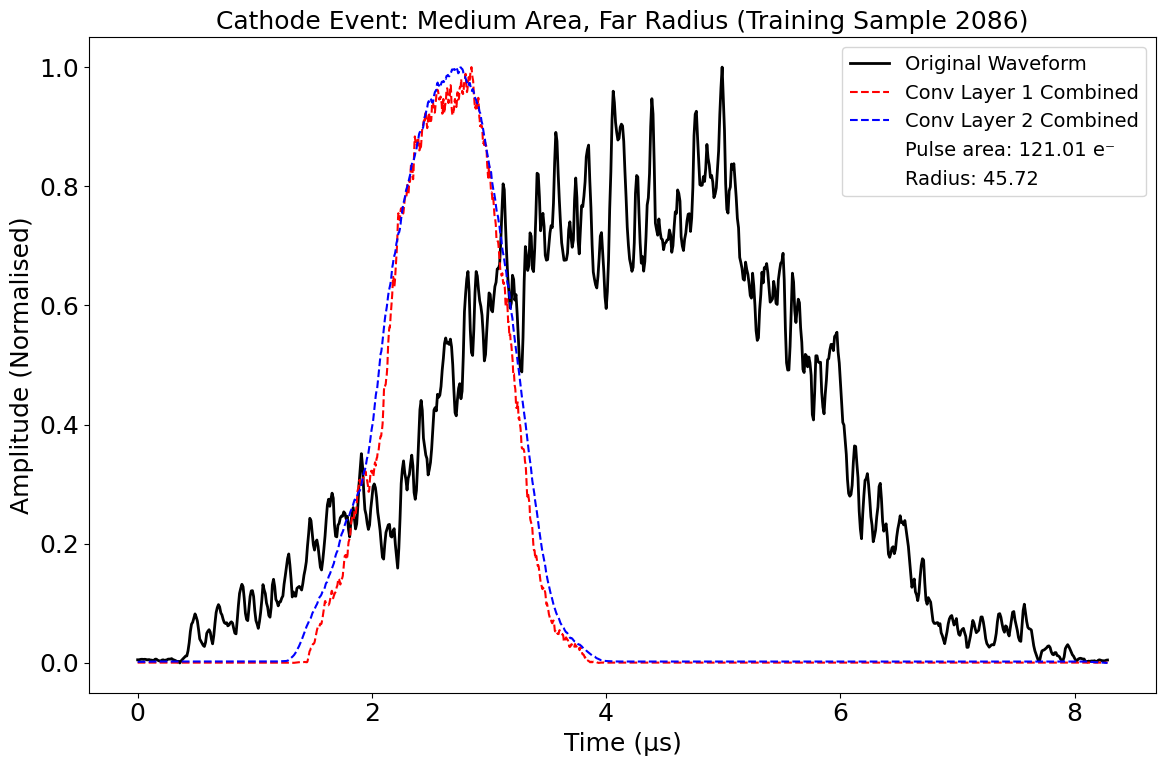


Cathode event - Area: Large, Radius: Close (Sample index 2357)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


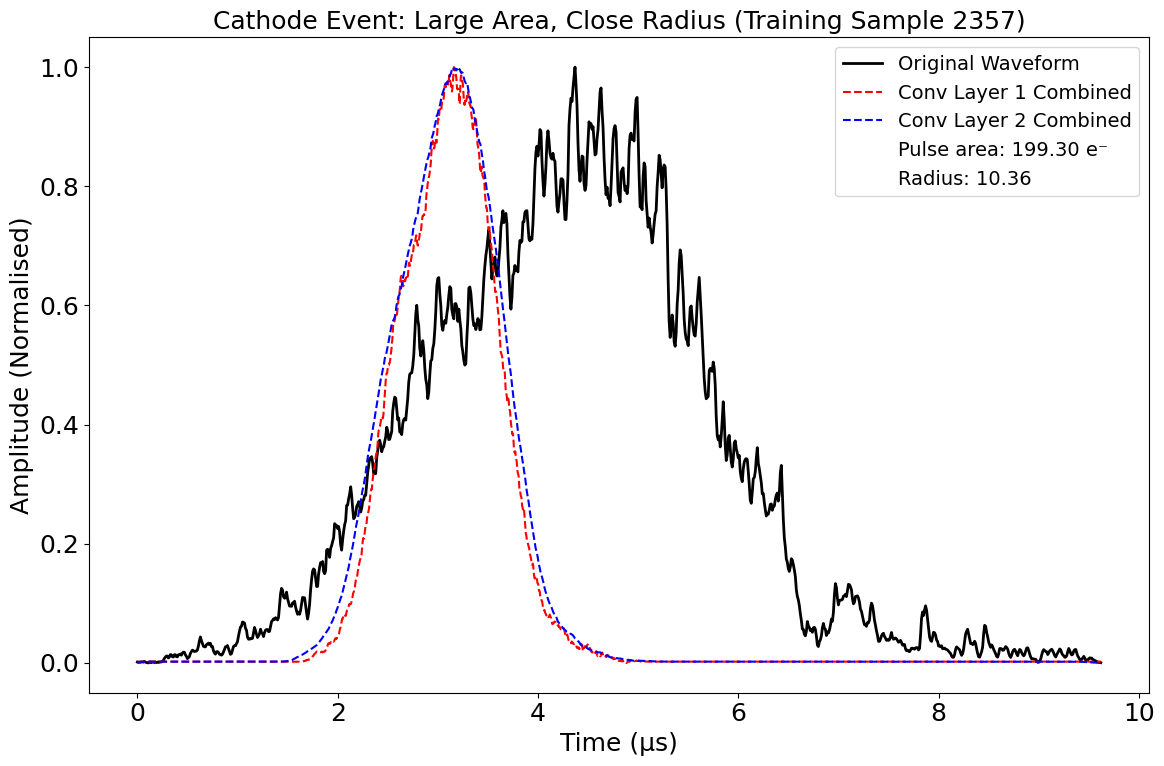


Cathode event - Area: Large, Radius: Medium (Sample index 2194)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


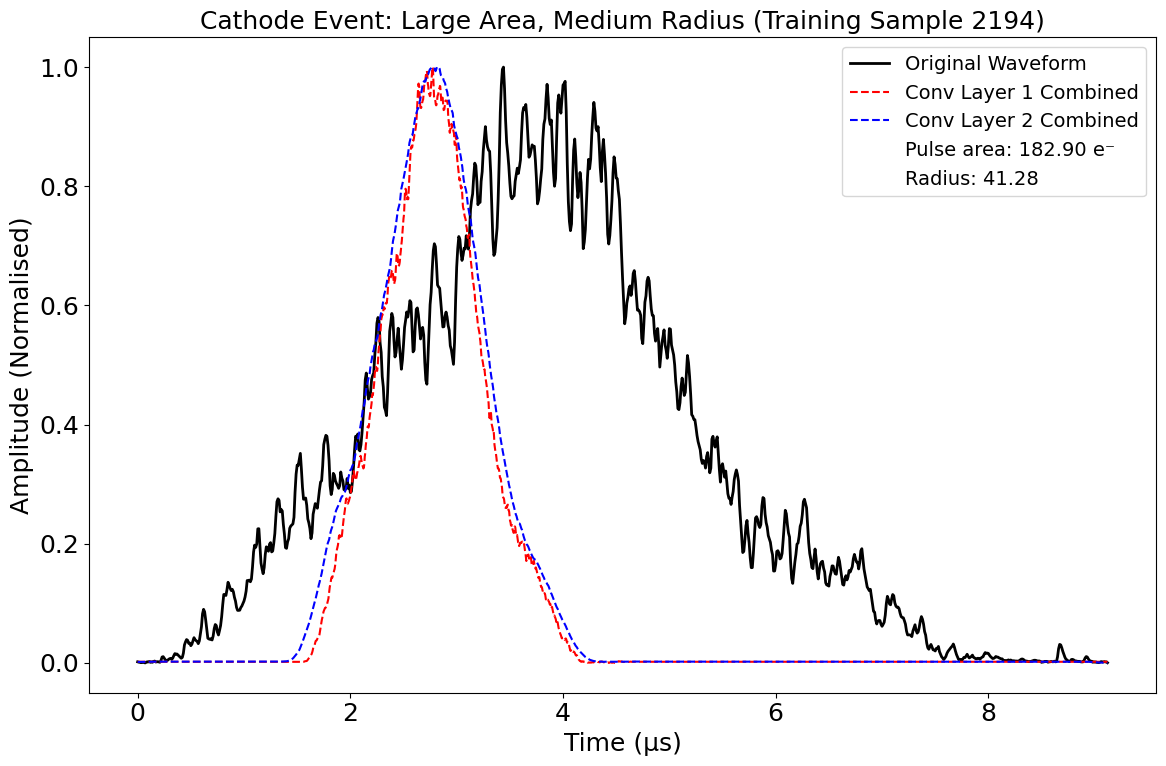


Cathode event - Area: Large, Radius: Far (Sample index 2014)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


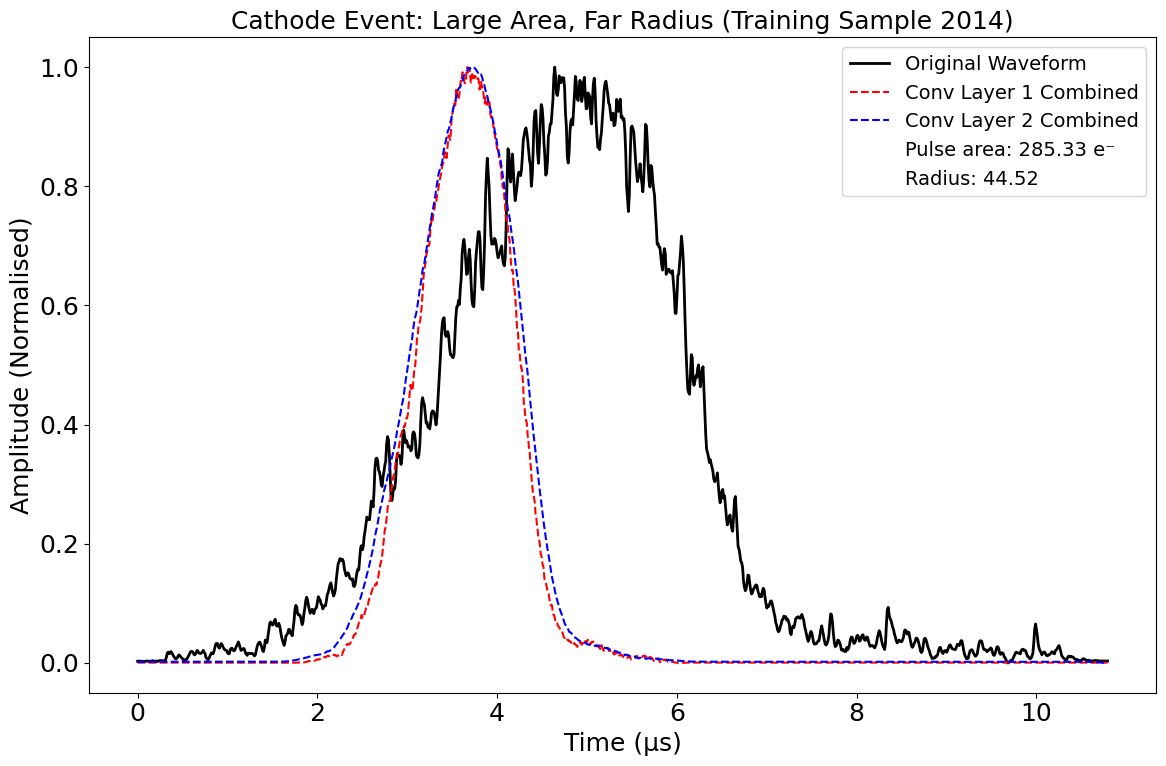


Gate event - Area: Small, Radius: Close (Sample index 136)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


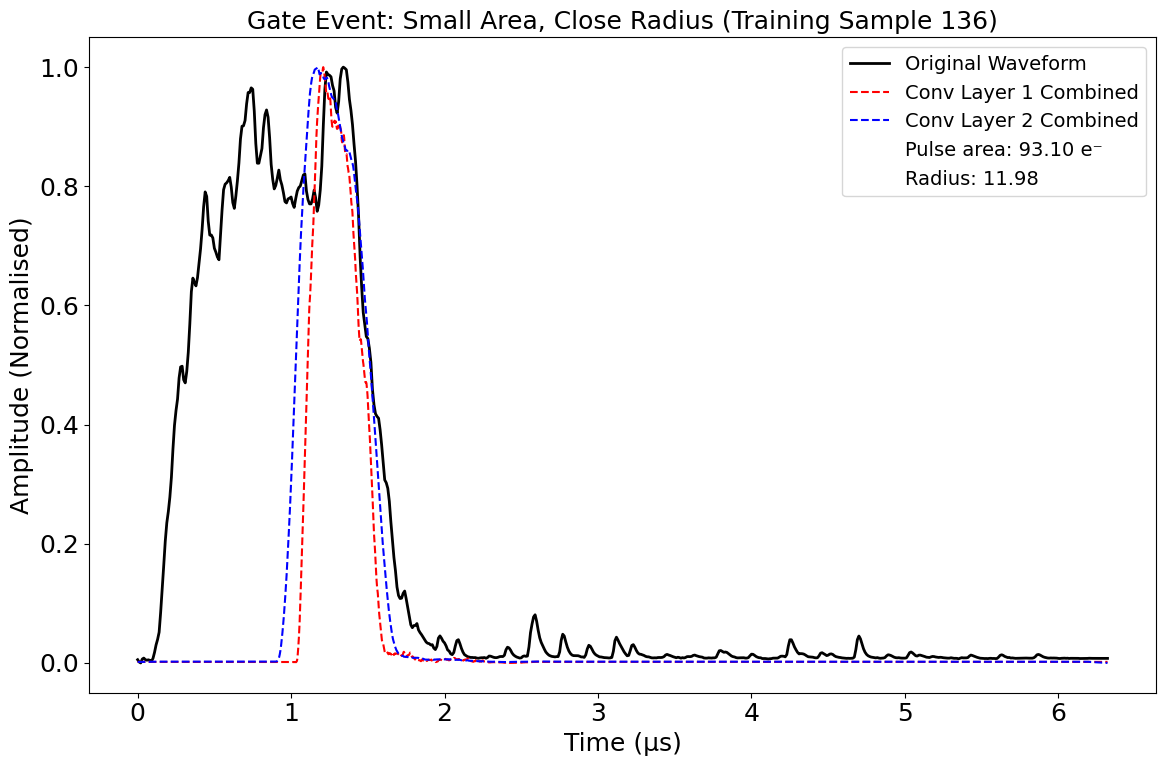


Gate event - Area: Small, Radius: Medium (Sample index 543)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


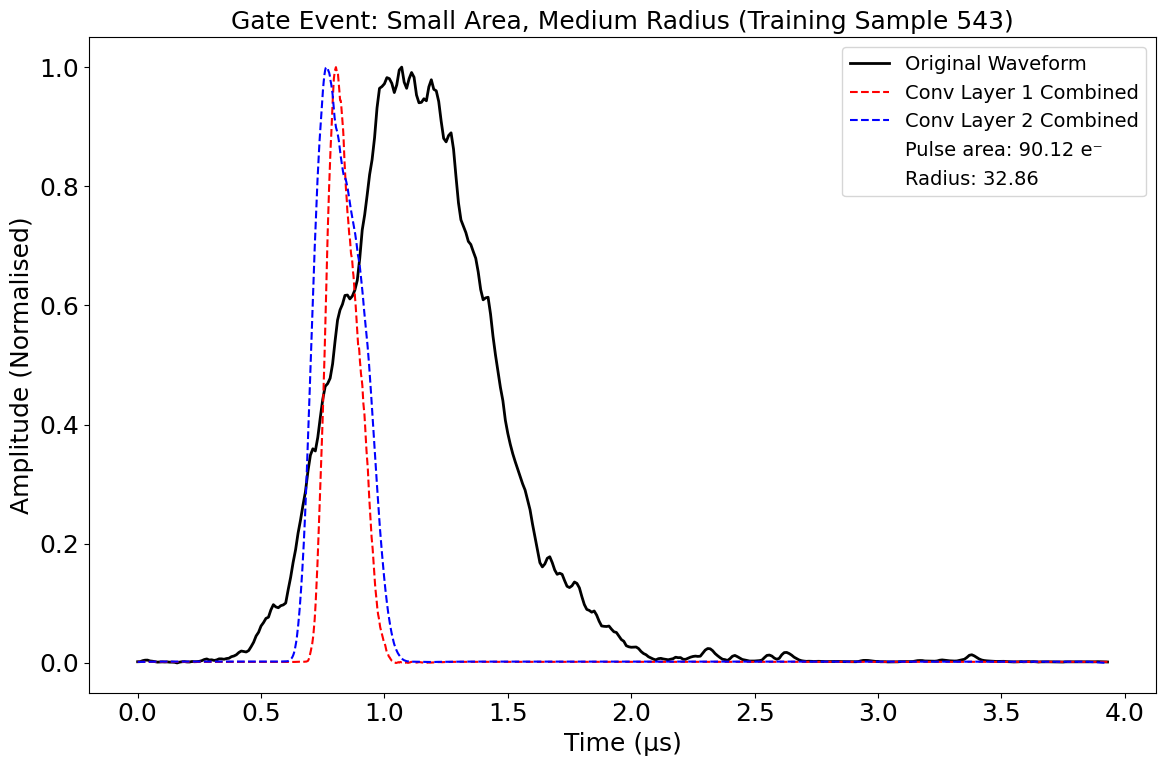


Gate event - Area: Small, Radius: Far (Sample index 1877)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


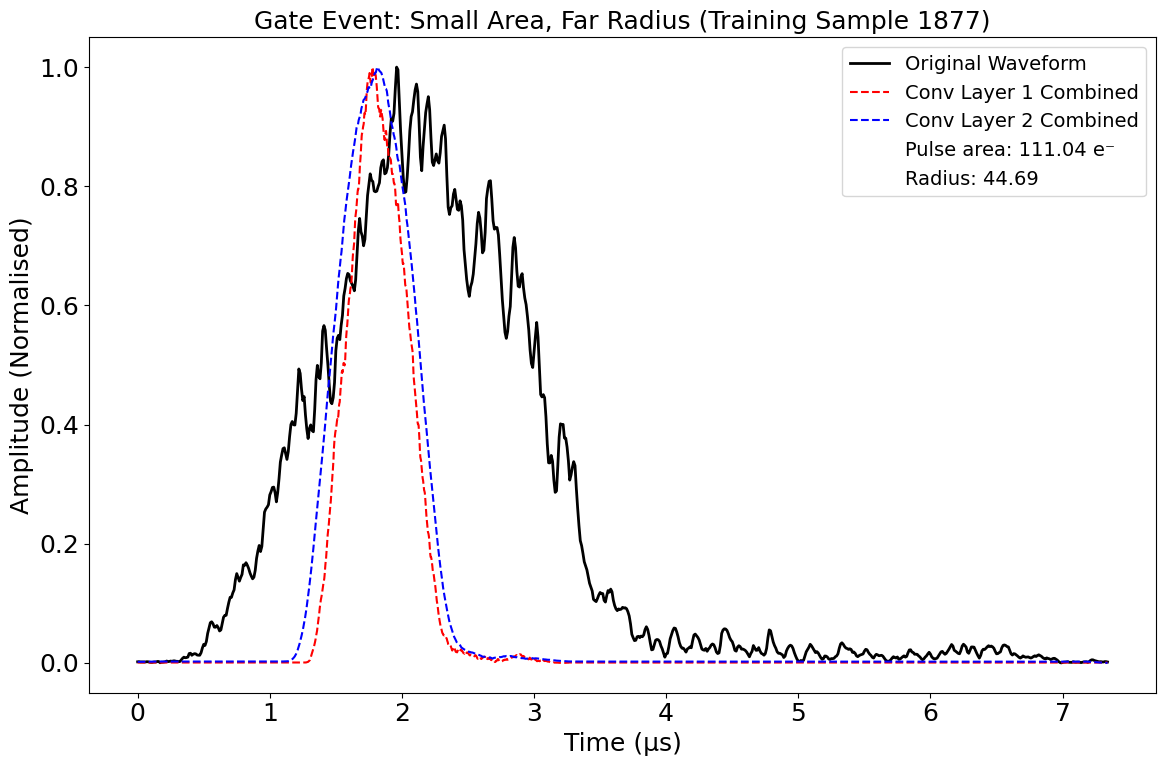


Gate event - Area: Medium, Radius: Close (Sample index 3190)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


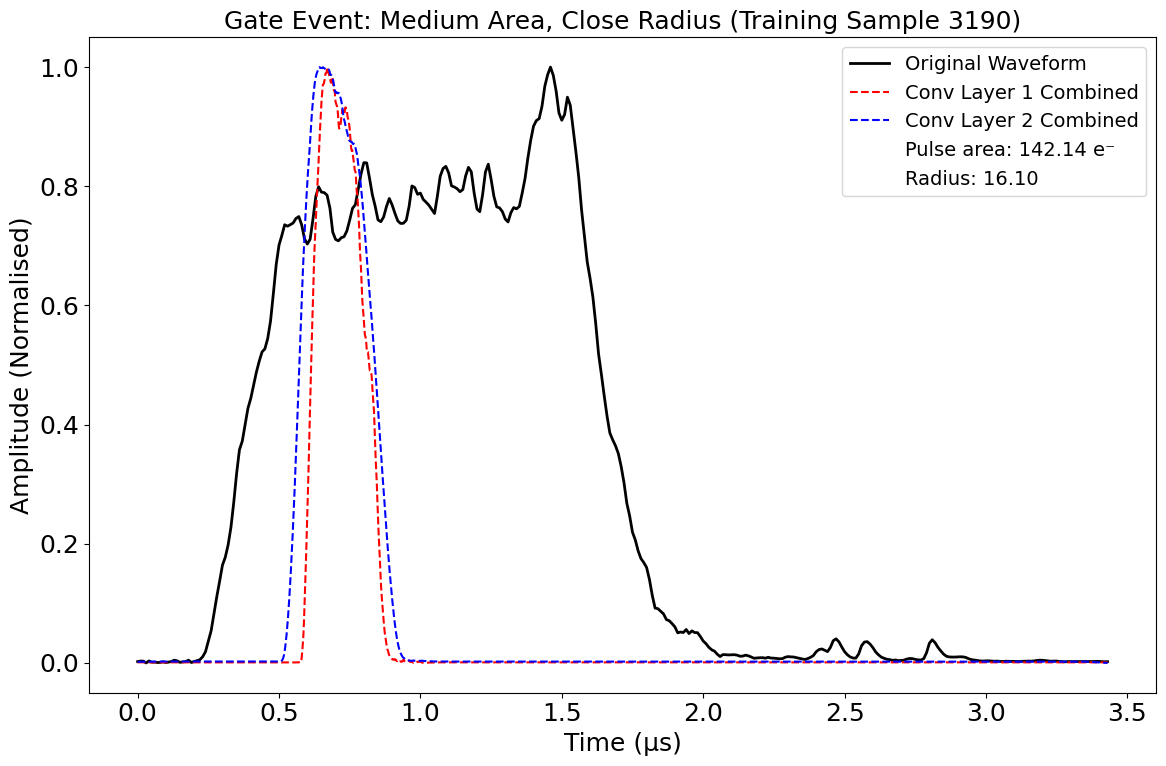


Gate event - Area: Medium, Radius: Medium (Sample index 2956)
1/1 [==============================] - 0s 15ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


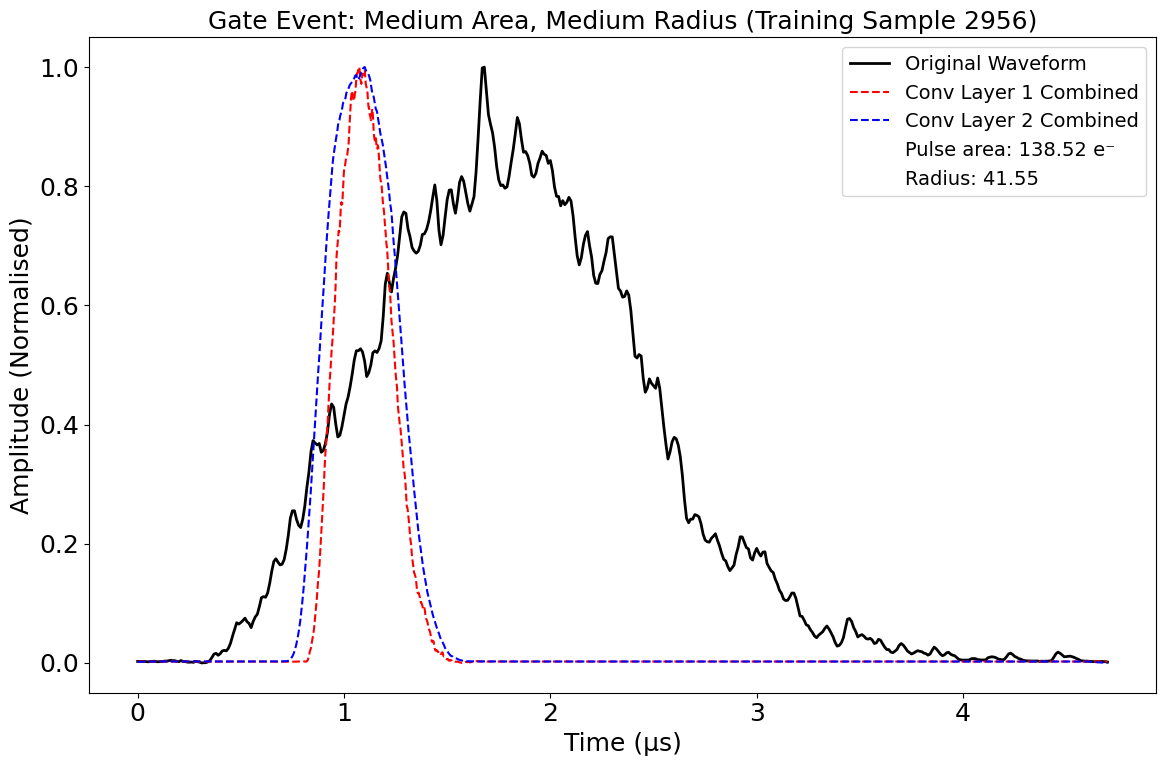


Gate event - Area: Medium, Radius: Far (Sample index 1852)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


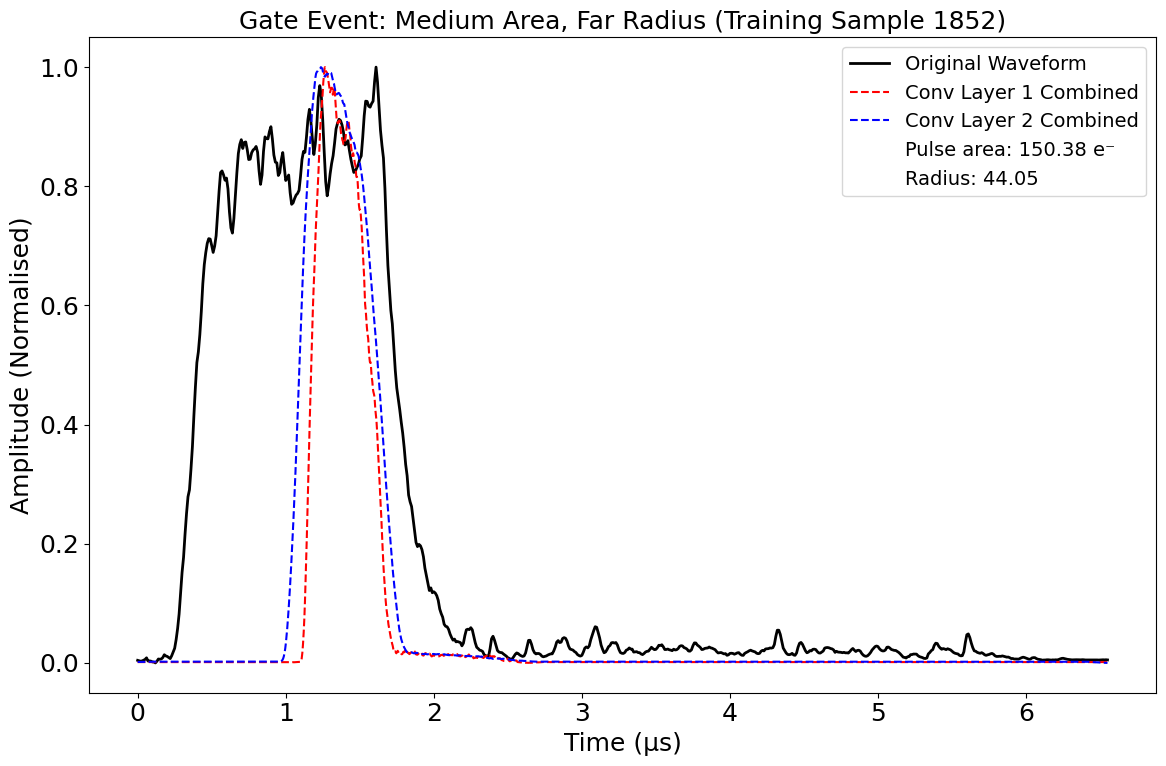


Gate event - Area: Large, Radius: Close (Sample index 1052)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


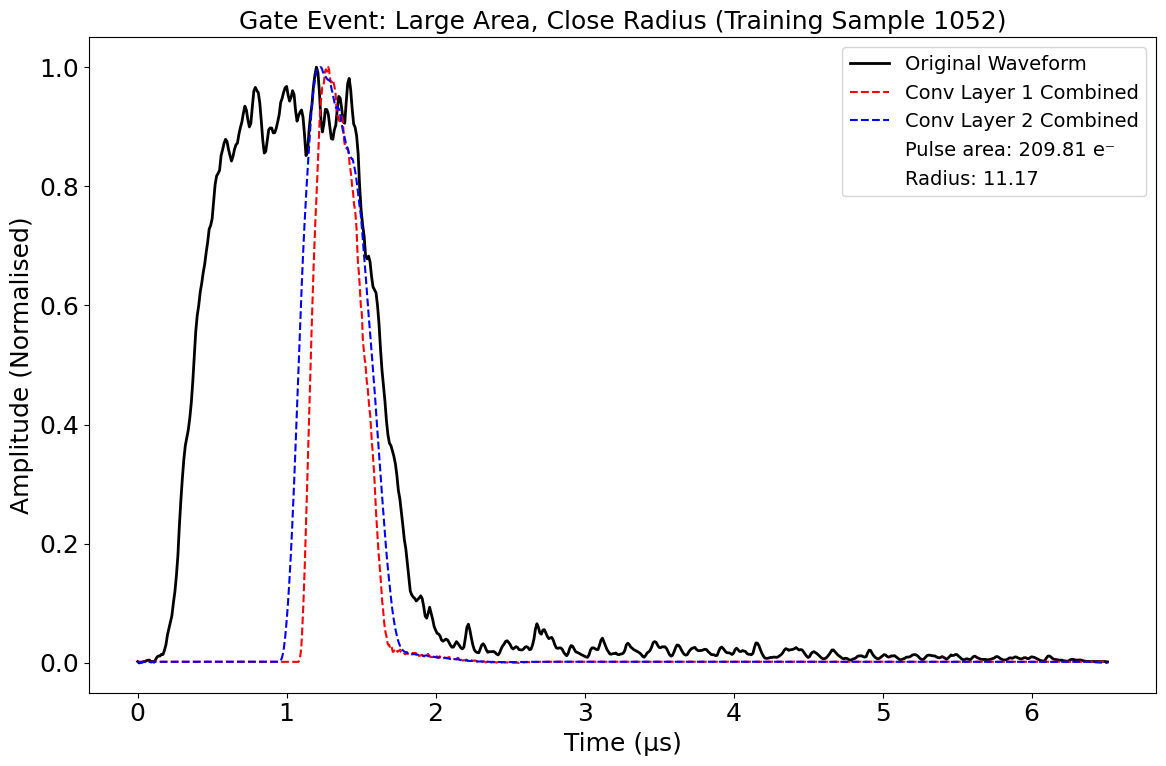


Gate event - Area: Large, Radius: Medium (Sample index 649)
1/1 [==============================] - 0s 48ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


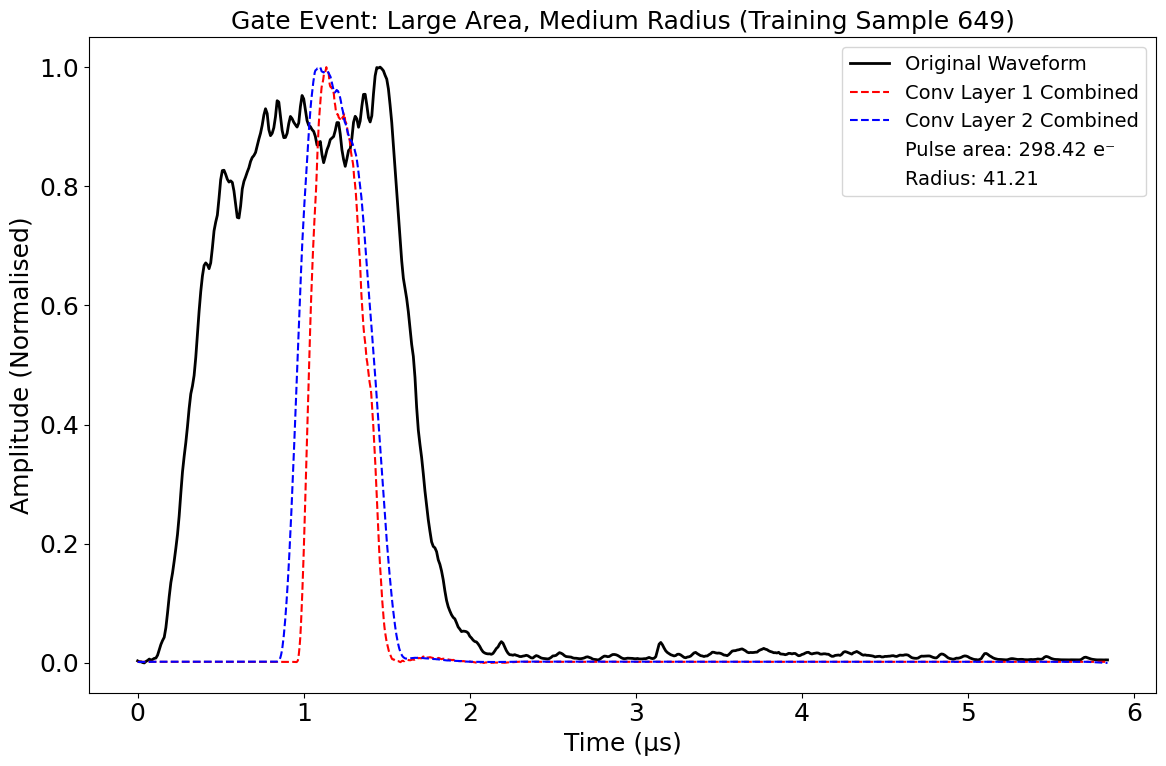


Gate event - Area: Large, Radius: Far (Sample index 1903)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


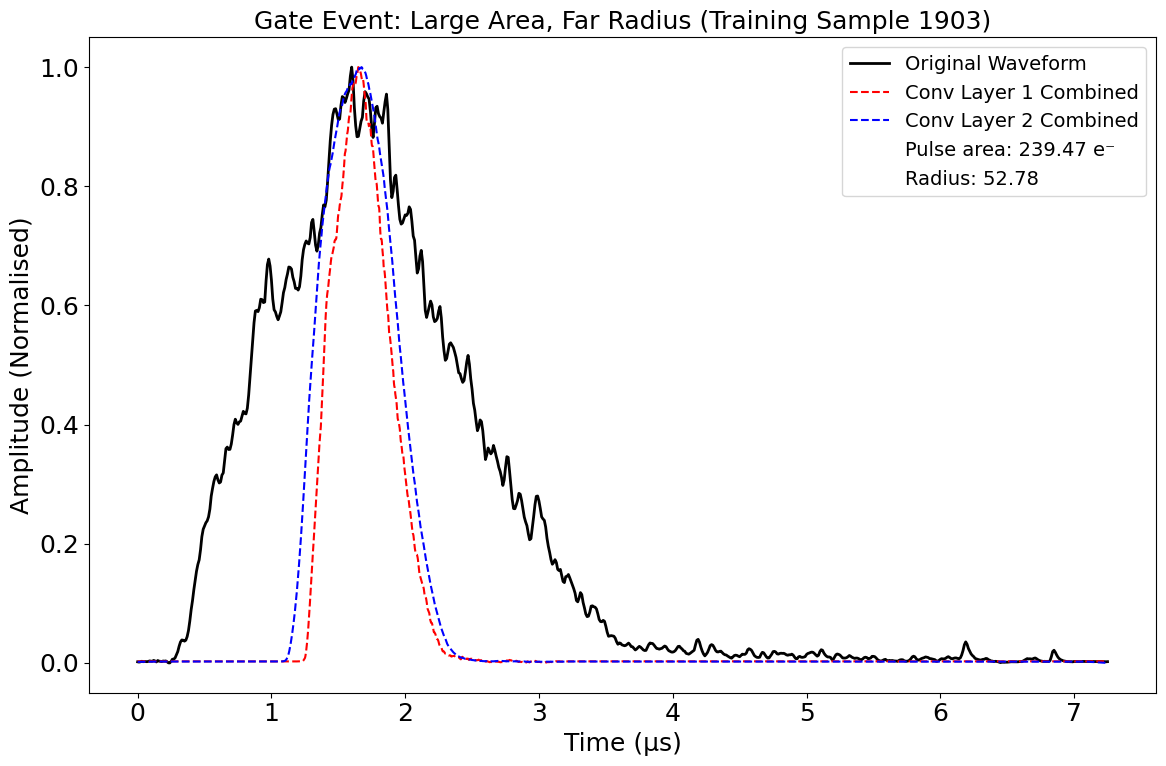


Tritium event - Area: Small, Radius: Close (Sample index 2029)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


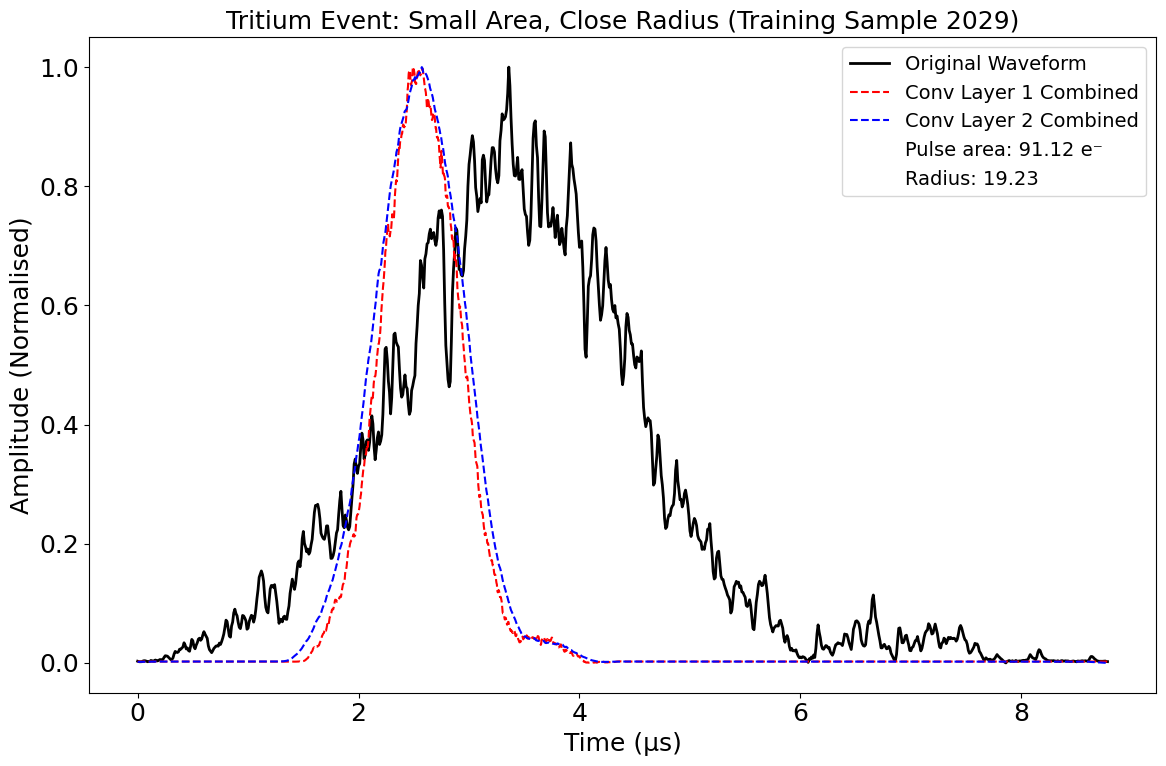


Tritium event - Area: Small, Radius: Medium (Sample index 1606)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


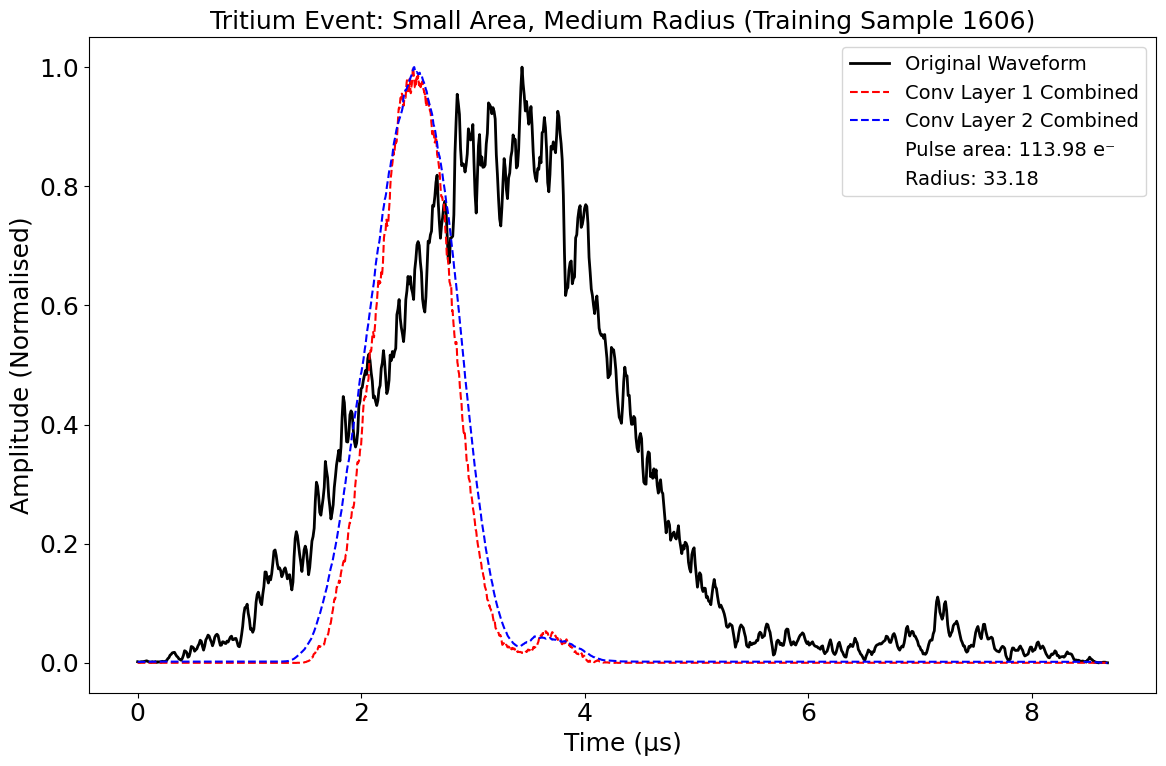


Tritium event - Area: Small, Radius: Far (Sample index 1364)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


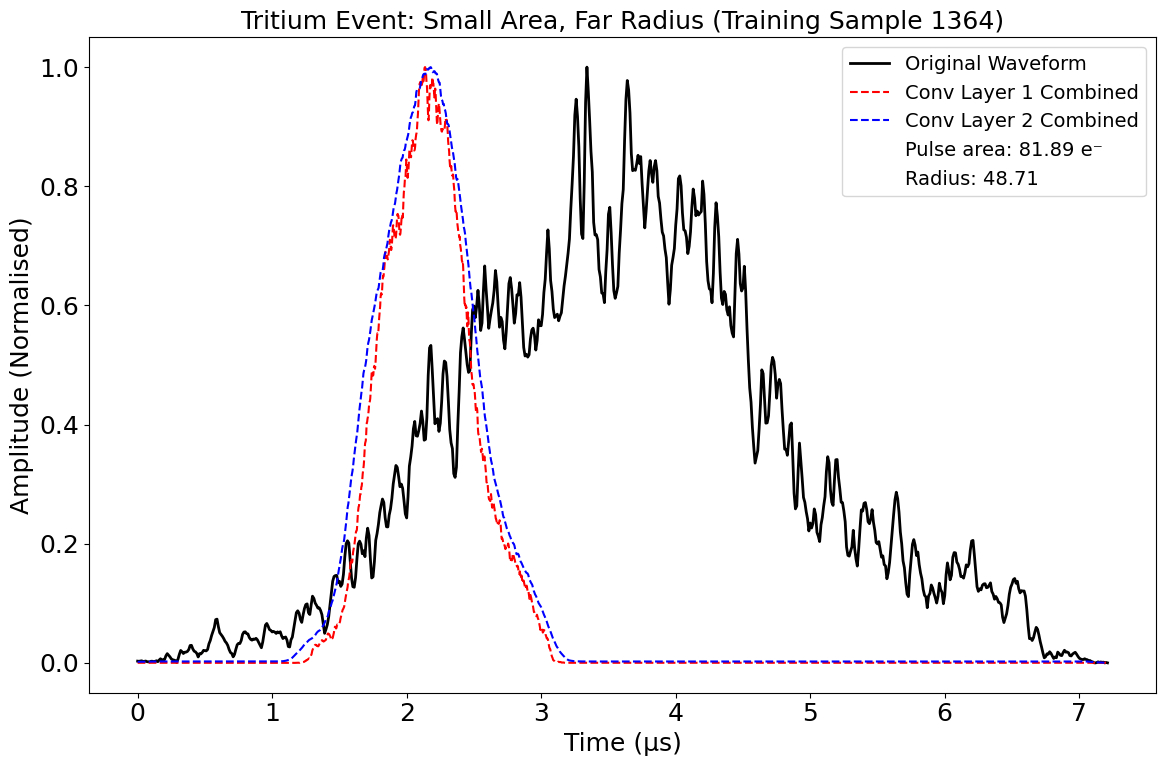


Tritium event - Area: Medium, Radius: Close (Sample index 2526)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


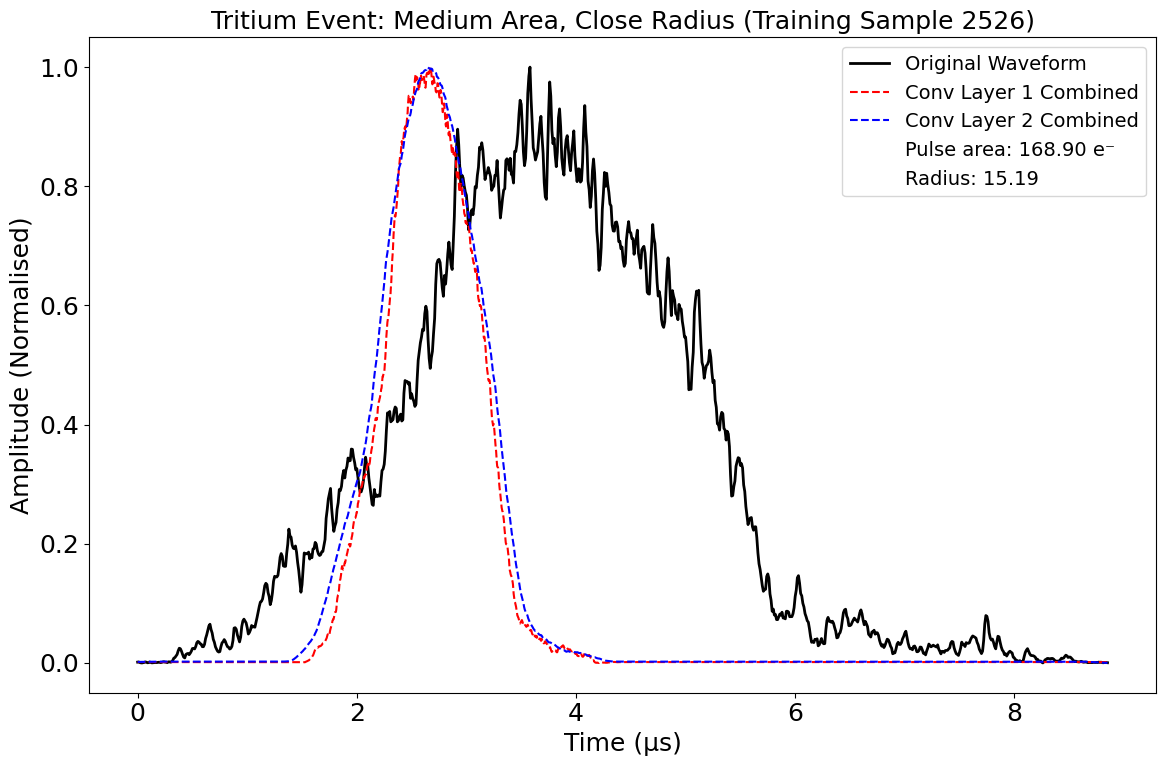


Tritium event - Area: Medium, Radius: Medium (Sample index 1026)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


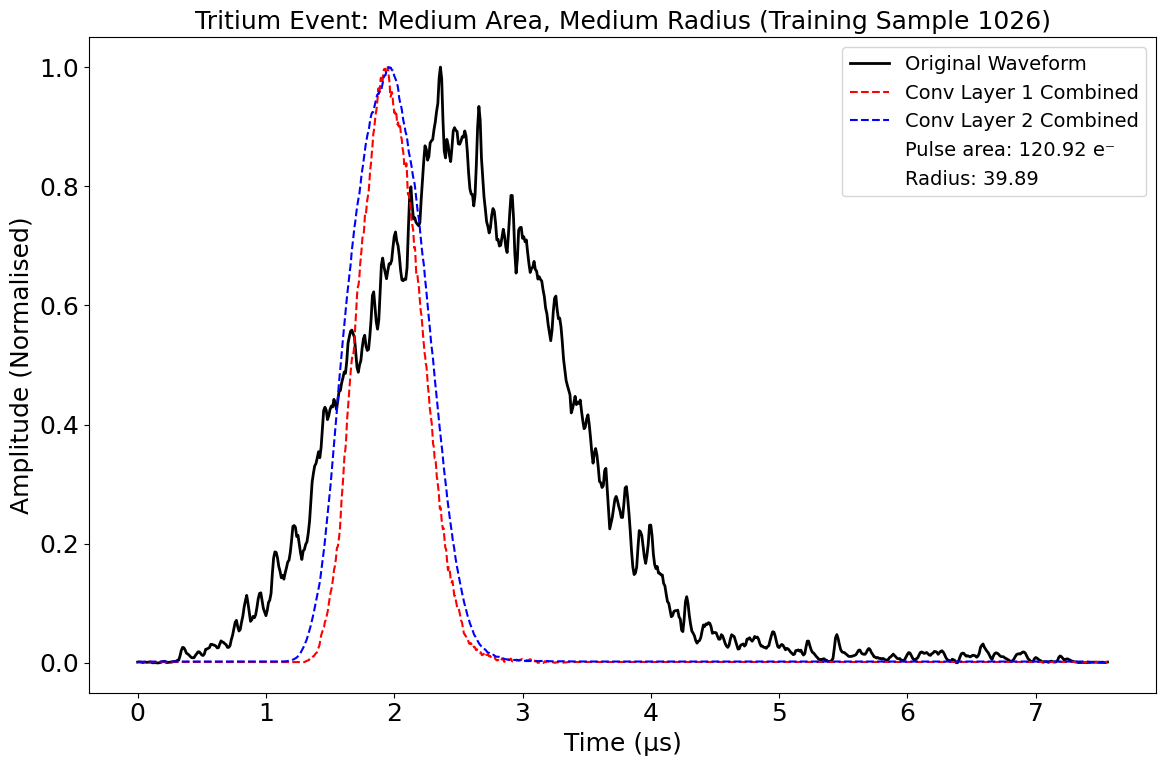


Tritium event - Area: Medium, Radius: Far (Sample index 856)
1/1 [==============================] - 0s 12ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


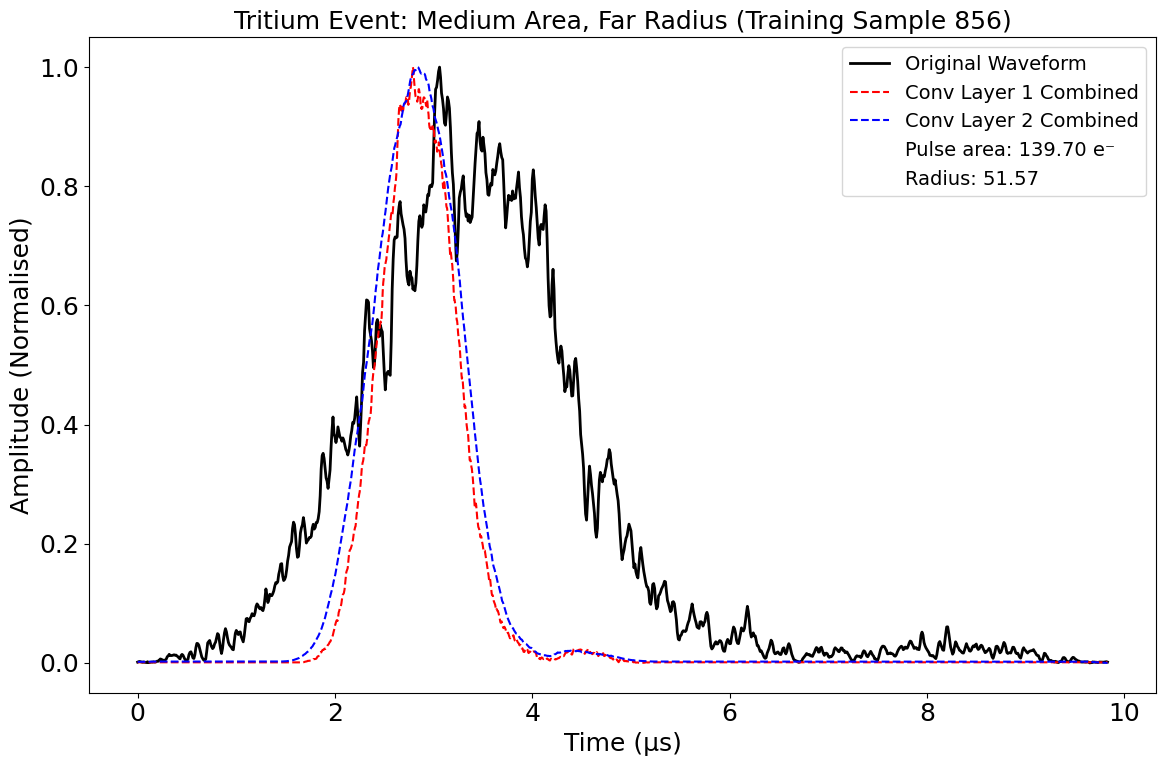


Tritium event - Area: Large, Radius: Close (Sample index 2386)
1/1 [==============================] - 0s 56ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


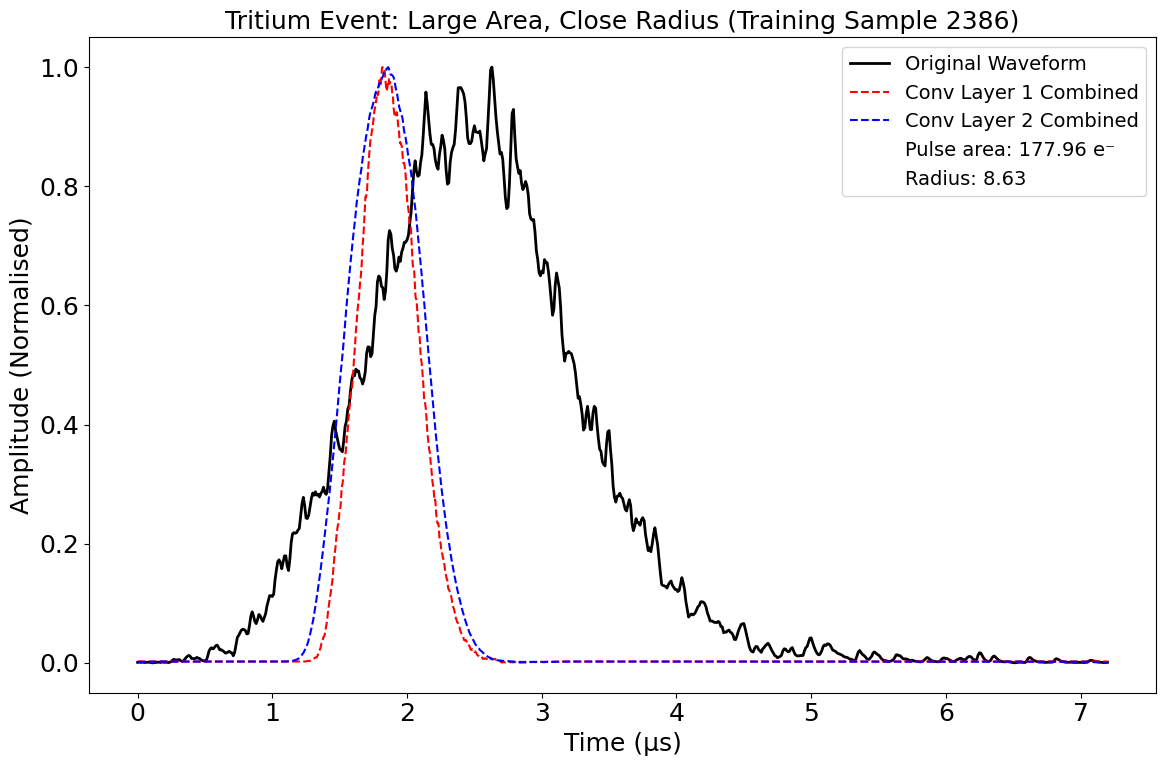


Tritium event - Area: Large, Radius: Medium (Sample index 2556)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


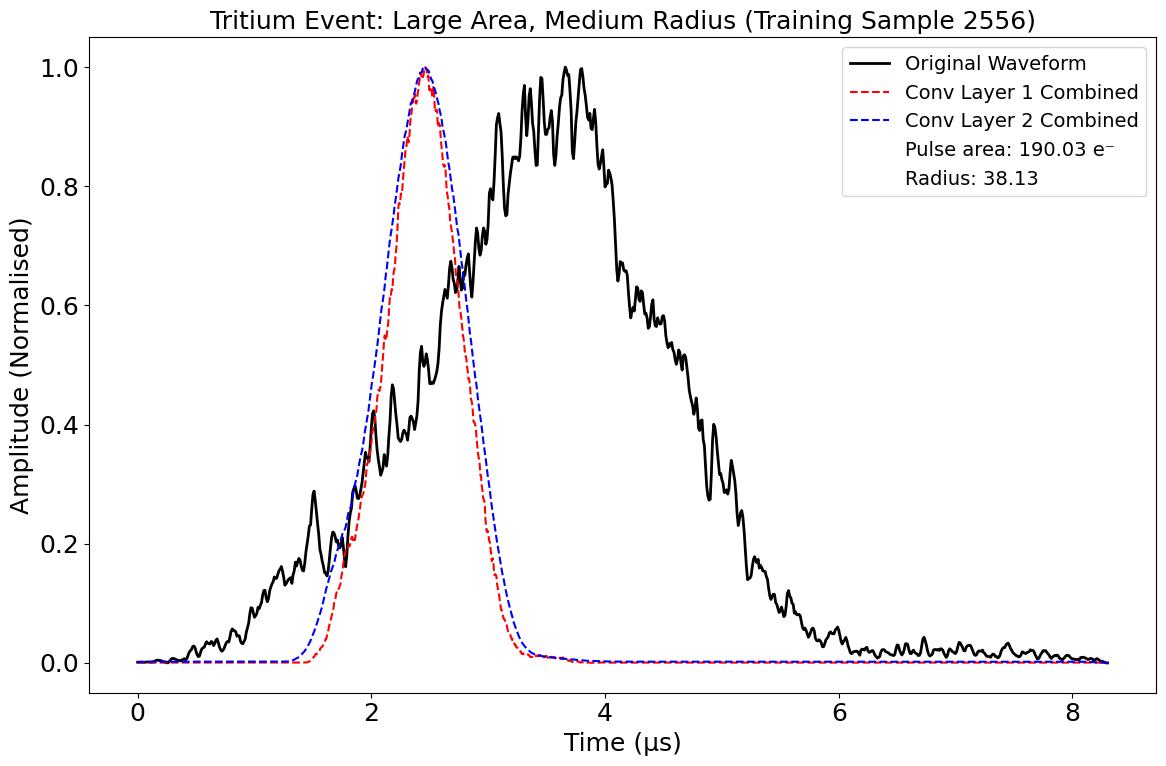


Tritium event - Area: Large, Radius: Far (Sample index 642)
1/1 [==============================] - 0s 13ms/step
Feature map shapes:
  Conv Layer 1: (1, 2828, 64)
  Conv Layer 2: (1, 1414, 64)


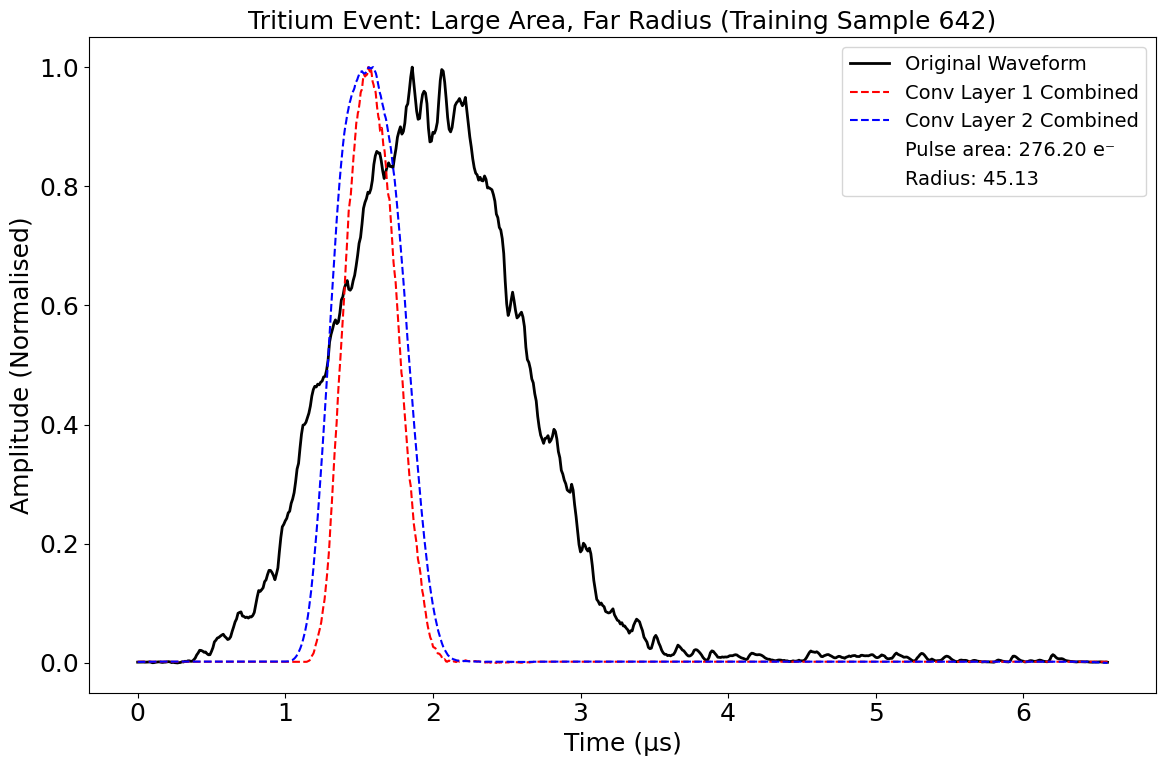

In [128]:
# Define the event types with their corresponding label numbers.
event_types = {
    "Cathode": 0,
    "Gate": 1,
    "Tritium": 2
}

# For each event type, select examples in a grid of (pulse area, radius) categories.
for event_name, event_label in event_types.items():
    # Get indices for this event type from y_train.
    event_indices = np.where(y_train == event_label)[0]
    
    # Get the pulse areas and radii for these indices.
    areas = area_train[event_indices]
    radii = r_train[event_indices]
    
    # Compute thresholds (33rd and 66th percentiles) for pulse area.
    area_small_thresh = np.percentile(areas, 33)
    area_large_thresh = np.percentile(areas, 66)
    # And for the radius.
    r_close_thresh = np.percentile(radii, 33)
    r_far_thresh = np.percentile(radii, 66)
    
    # Define lambda functions for categorizing pulse area.
    area_categories = {
        "Small": lambda x: x < area_small_thresh,
        "Medium": lambda x: (x >= area_small_thresh) & (x <= area_large_thresh),
        "Large": lambda x: x > area_large_thresh
    }
    # And for the radius.
    radius_categories = {
        "Close": lambda x: x < r_close_thresh,
        "Medium": lambda x: (x >= r_close_thresh) & (x <= r_far_thresh),
        "Far": lambda x: x > r_far_thresh
    }
    
    # Loop over each combination of pulse area category and radius category.
    for area_cat, area_func in area_categories.items():
        for radius_cat, radius_func in radius_categories.items():
            # Filter the indices for which both the pulse area and radius satisfy the category.
            cat_indices = [idx for idx in event_indices 
                           if area_func(area_train[idx]) and radius_func(r_train[idx])]
            if len(cat_indices) == 0:
                print(f"No {event_name} events for area {area_cat} and radius {radius_cat}.")
                continue  # Skip if there is no event matching this combination.
            
            # Randomly choose one sample index from the filtered list.
            sample_index = np.random.choice(cat_indices)
            
            print(f"\n{event_name} event - Area: {area_cat}, Radius: {radius_cat} (Sample index {sample_index})")
            
            # --- Process and Plot the Selected Sample ---
            # Extract the sample input (with a batch dimension) for the CNN.
            sample_input = X_train_padded[sample_index:sample_index+1]
            
            # Run the sample through the intermediate feature model.
            feature_maps = feature_model.predict(sample_input)
            
            # Print the feature map shapes for debugging.
            print("Feature map shapes:")
            for i, fmap in enumerate(feature_maps):
                print(f"  Conv Layer {i+1}: {fmap.shape}") 
            """
            The shape (B, T, F) of the feature map tells you about the structure of the output from a convolutional layer. Here's what each number represents:

            1. Batch Size:
            This indicates that the feature map comes from a single sample (one input) that was passed through the network. In many deep learning frameworks the output retains a batch dimension.

            2. Temporal Steps:
            This number represents the length of the output along the time axis (if you're working with time-series data) AFTER applying the convolution (and possibly pooling, padding, etc.), the output has T distinct positions (or time steps).

            3. Number of Filters (Channels):
            For each of the T positions, the layer produces F separate activation values — one from each filter. Each filter is responsible for detecting a different type of feature from the input data.
            """
            # Retrieve the original waveform and its time axis.
            waveform = normalised_samples_train[sample_index]
            time_axis = times_us_train[sample_index]  # Already converted to microseconds.
            
            # Compute the amplitude range of the waveform.
            waveform_min = np.min(waveform)
            waveform_max = np.max(waveform)
            waveform_range = waveform_max - waveform_min
            
            # Create a new figure.
            plt.figure(figsize=(12, 8))
            
            # Plot the original waveform.
            plt.plot(time_axis, waveform, label='Original Waveform', color='black', linewidth=2)
            
            # Define some colors for different convolutional layers.
            colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
            
            # Loop over each convolutional layer's feature map.
            for i, fmap in enumerate(feature_maps):
                # Each fmap is of shape (1, time_steps_layer, num_filters).
                # Sum over the filter dimension (axis = -1) to aggregate activations.
                # Then [0] removes the batch dimension.
                combined_map = np.sum(fmap, axis=-1)[0]
                
                # Create a new time axis for the combined feature map.
                t_feature = np.linspace(time_axis[0], time_axis[-1], num=combined_map.shape[0])
                
                # Rescale the combined map:
                combined_shifted = combined_map - np.min(combined_map)
                if np.max(combined_shifted) != 0:
                    combined_normalized = combined_shifted / np.max(combined_shifted)
                else:
                    combined_normalized = combined_shifted
                scaled_combined = combined_normalized * waveform_range + waveform_min
                
                # Plot the scaled combined feature map.
                plt.plot(t_feature, scaled_combined, label=f'Conv Layer {i+1} Combined', 
                         linestyle='--', color=colors[i % len(colors)])
            
            # Add dummy entries to the legend for pulse area and radius.
            pulse_area = area_train[sample_index]
            event_radius = r_train[sample_index]
            plt.plot([], [], color='none', linestyle='none', marker='None',
                     label=f"Pulse area: {pulse_area:.2f} e⁻")
            plt.plot([], [], color='none', linestyle='none', marker='None',
                     label=f"Radius: {event_radius:.2f}")
            
            # Finalise the plot.
            plt.xlabel("Time (µs)")
            plt.ylabel("Amplitude (Normalised)")
            plt.title(f"{event_name} Event: {area_cat} Area, {radius_cat} Radius (Training Sample {sample_index})", fontsize=18)
            plt.legend(fontsize=14)
            plt.tight_layout()
            plt.show()

## Aside: Dataset of Filter Activations

In [133]:
# We want to look at the activations from the first convolutional layer:
# shape of feature_maps[0] is (1, T, F)

# Remove the batch dimension:
activations = feature_maps[0][0]  # Now activations.shape is (T, F)

# Optionally, if you have a time axis (for example, t_feature) that matches the T time steps,
# you can use it as the index. Otherwise, we'll just use the row numbers.
T, F = activations.shape # [rows, columns]
# Create column names for the filters:
columns = [f"filter {i}" for i in range(F)]
# Create a DataFrame:
df = pd.DataFrame(activations, columns=columns)
# Optionally, set the index to represent the time steps if you have a corresponding time axis.
# For example, if t_feature is a numpy array of length T:
# df.index = t_feature

# Display the DataFrame:
print(df)

      filter 0  filter 1  filter 2  filter 3  filter 4  filter 5  filter 6  \
0     0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
1     0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
2     0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
3     0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
4     0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
2823  0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
2824  0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
2825  0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
2826  0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   
2827  0.000281  0.001247       0.0       0.0       0.0       0.0       0.0   

      filter 7  filter 8  filter 9  ...  filter 54  filter 55  

## Saliency Maps (Using Guided Backpropagation)

In [134]:
def guided_backprop(model, waveform_input, class_idx):
    """
    Generate guided backpropagation for a 1D waveform input with improved visualisation properties
    
    Parameters:
    -----------
    model : keras.Model
        Trained model
    waveform_input : ndarray
        Input waveform with shape (time_steps, 1) or (1, time_steps, 1)
    class_idx : int
        Index of the class to generate visualisation for
        
    Returns:
    --------
    guided_grads : ndarray
        Guided backpropagation with same shape as input, processed for better visualisation
    """
    # Custom activation with modified gradient
    @tf.custom_gradient
    def guided_relu(x):
        y = tf.nn.relu(x)
        def grad(dy):
            return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
        return y, grad
    
    # Create a copy of the model with guided ReLU
    guided_model = tf.keras.models.clone_model(model)
    guided_model.set_weights(model.get_weights())
    
    # Replace ReLU activations with guided ReLU
    for layer in guided_model.layers:
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu
    
    # Ensure waveform has batch dimension
    if len(waveform_input.shape) == 2:
        waveform_input = np.expand_dims(waveform_input, axis=0)
    elif len(waveform_input.shape) == 1:
        waveform_input = np.expand_dims(np.expand_dims(waveform_input, axis=-1), axis=0)
    
    # Convert to Tensor
    waveform_tensor = tf.convert_to_tensor(waveform_input, dtype=tf.float32)

    # Compute gradients w.r.t. the input waveform
    with tf.GradientTape() as tape:
        tape.watch(waveform_tensor)
        predictions = guided_model(waveform_tensor)
        loss = predictions[:, class_idx]
    
    gradients = tape.gradient(loss, waveform_tensor)
    raw_gradients = gradients.numpy()[0, :, 0]  # Remove batch and channel dimensions
    
    # Post-process gradients for better visualisation:
    # Take absolute values to focus on importance rather than direction
    abs_gradients = np.abs(raw_gradients)
    
    # Smooth the gradients slightly to reduce noise (optional)
    # Using a simple moving average filter
    window_size = 3
    if len(abs_gradients) > window_size:
        smoothed_gradients = np.convolve(abs_gradients, np.ones(window_size)/window_size, mode='same')
    else:
        smoothed_gradients = abs_gradients
    
    # Normalise to [0,1] range
    if np.max(smoothed_gradients) > 0:  # Avoid division by zero
        normalised_gradients = smoothed_gradients / np.max(smoothed_gradients)
    else:
        normalised_gradients = smoothed_gradients
    
    return normalised_gradients  # Return the processed gradients

## Grad1D-CAM

In [135]:
import matplotlib.cm as cm
import scipy
import math

def gradcam_1d(model, waveform_input, class_idx, layer_name=None):
    """
    Generate Grad-CAM heatmap for a 1D waveform input
    
    Parameters:
    -----------
    model : keras.Model
        Trained model
    waveform_input : ndarray
        Input waveform with shape (time_steps, 1) or (1, time_steps, 1)
    class_idx : int
        Index of the class to generate visualization for
    layer_name : str, optional
        Name of the layer to use for Grad-CAM. If None, uses the last conv layer.
        
    Returns:
    --------
    heatmap : ndarray
        Grad-CAM heatmap with same length as the input waveform normalised to scale of original waveform.
    """
    # Ensure waveform has batch dimension
    if len(waveform_input.shape) == 2:
        waveform_input = np.expand_dims(waveform_input, axis=0)
    elif len(waveform_input.shape) == 1:
        waveform_input = np.expand_dims(np.expand_dims(waveform_input, axis=-1), axis=0)   
    
    # If no layer_name given, find last Conv1D in the original model
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, keras.layers.Conv1D):
                layer_name = layer.name # takes the first Conv1D layer it finds when iterating in reverse, which by definition is the last Conv1D layer in the model's forward path.
                break
    
    
    # Build a new model that outputs the chosen conv layer + the final output
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(layer_name).output,
            model.output
        ]
    )
    
    # Compute gradient of the target class with respect to the output feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(waveform_input)
        loss = predictions[:, class_idx]
    
    # Extract gradients and convolutional output
    grads = tape.gradient(loss, conv_output) # tape.gradient is a function provided by TensorFlow's GradientTape API.
    # Calculating how much the loss (which is the prediction score for the target class) would change if you made small changes
    # to the conv_output (the feature maps from your convolutional layer).
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1)) # Averages gradients across the temporal dimension to get global importance weight per feature channel.
    
    # Weight the output feature map with the gradients
    conv_output = conv_output[0] # removing the batch dimension.
    # The original conv_output has shape (batch_size, time_steps, channels) where batch_size is 1 in our case. 
    # By taking conv_output[0], the code extracts just the first sample from the batch, resulting in a tensor of shape (time_steps, channels).
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1) # applies scalar weight to each feature map to create global Nfilter-dimension aggregated feature map
    """The tf.reduce_sum(..., axis=-1) operation collapses all the weighted feature channels (last dimension) at each time point into a single value.
        So for each time point in the waveform:

        1. We have multiple feature channels (from the convolutional layer)
        2. Each channel has been weighted by its importance
        3. The sum combines these weighted values into a single number which is then converted into a corresponding heat signature.

    """
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

# Advanced Technique Visualisations: Saliency (with Guided Backprop.) and Grad1D-CAM

In [137]:
def visualise_waveform_with_gradient_analysis(
    sample_index, 
    time_axis, 
    model, 
    class_idx, 
    class_names=None, 
    area=None, 
    radius=None,
    use_gradcam=True,
    use_guided_backprop=True
):
    """
    Visualise a waveform with attention mechanisms to highlight important features
    
    Parameters:
    -----------
    sample_index : int
        Index of the sample to visualise
    time_axis : ndarray
        Time values corresponding to the waveform
    model : keras.Model
        Trained model
    class_idx : int
        Index of the class to generate visualisation for
    class_names : list, optional
        Names of the classes
    area : float, optional
        Area value for the event
    radius : float, optional
        Radius value for the event
    use_gradcam : bool
        Whether to show Grad-CAM visualisation
    use_guided_backprop : bool
        Whether to show guided backpropagation
    """
    if class_names is None:
        class_names = ['Cathode', 'Gate', 'Tritium']

    # Get the input data
    model_input = X_test_padded[sample_index:sample_index+1]
    waveform = normalised_samples_test[sample_index]
    
    # Get model prediction
    prediction = model.predict(model_input)
    predicted_class = np.argmax(prediction[0])
    prediction_confidence = prediction[0, predicted_class]
    
    # Create visualisation figure
    fig, axes = plt.subplots(2 if use_gradcam and use_guided_backprop else 1, 
                             1, figsize=(12, 10 if use_gradcam and use_guided_backprop else 6))
    
    if not use_gradcam and not use_guided_backprop:
        ax = axes
    else:
        ax = axes[0] if use_gradcam and use_guided_backprop else axes

    # Plot original waveform
    ax.plot(time_axis, waveform, 'k-', label='Original Waveform', linewidth=2)
    
    # Add title and stats
    #ax.set_title(f"Waveform Classification: {class_names[predicted_class]} (Confidence: {prediction_confidence:.2f})", 
                 #fontsize=16)
    
    # Add info about area and radius if available
    info_text = f"True Class: {class_names[class_idx]}\n"
    info_text += f"Predicted Class: {class_names[predicted_class]}\n"
    info_text += f"Predicted Probability: {prediction_confidence:.2f}\n"
    if area is not None:
        info_text += f"Area: {area:.2f} electrons\n"
    if radius is not None:
        info_text += f"Radius: {radius:.2f}\n"
    
    # Add a text box with information
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.6, 0.40, info_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    
    if use_gradcam:
        # Calculate Grad-CAM
        heatmap = gradcam_1d(model, model_input, class_idx)
        
        # If the heatmap length doesn't match the waveform, resize it
        if len(heatmap) != len(waveform):
            zoom_factor = len(waveform) / len(heatmap)
            heatmap = scipy.ndimage.zoom(heatmap, zoom_factor)
        
        # Create a colourmap for the heatmap
        cmap = plt.cm.jet
        colours = cmap(heatmap)
        
        # Plot the heatmap as a coloured background
        for i in range(len(time_axis)-1):
            ax.axvspan(time_axis[i], time_axis[i+1], alpha=0.3, color=colours[i])
        
        # Add a colourbar for the heatmap
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Class Activation Intensity')
    
    ax.set_xlabel('Time (μs)', fontsize=16)
    ax.set_ylabel('Amplitude (Normalised)', fontsize=16)
    ax.legend(loc='upper right', fontsize=16)
    
    if use_guided_backprop:
        if use_gradcam:  # If both visualisations are used
            ax = axes[1]
        
        # Calculate guided backpropagation
        # The updated guided_backprop function now returns normalised [0,1] values
        guided_grads = guided_backprop(model, model_input, class_idx)
        
        # Ensure guided_grads has the same length as time_axis
        if len(guided_grads) != len(time_axis):
            # Resample to match the time_axis length
            guided_grads = scipy.ndimage.zoom(guided_grads, len(time_axis) / len(guided_grads))
        
        # Get min/max of waveform for scaling
        waveform_min = np.min(waveform)
        waveform_max = np.max(waveform)
        waveform_range = waveform_max - waveform_min
        
        # Scale the normalized gradients to match the waveform's amplitude range
        # and shift to start from the waveform's minimum value
        scaled_guided_grads = guided_grads * waveform_range + waveform_min
        
        # Plot the original waveform
        ax.plot(time_axis, waveform, 'k-', label='Original Waveform', linewidth=2)
        
        # Plot the guided backpropagation as a line
        ax.plot(time_axis, scaled_guided_grads, 'r-', label='Saliency Map', alpha=0.7, linewidth=2)
        
        # Add the filled area below the saliency line
        ax.fill_between(time_axis, waveform_min, scaled_guided_grads, color='r', alpha=0.2)
        
        #ax.set_title('Saliency Map: Guided Backpropagation Analysis', fontsize=16)
        ax.set_xlabel('Time (μs)', fontsize=16)
        ax.set_ylabel('Amplitude', fontsize=16)
        ax.legend(loc='upper right', fontsize=16)
    
    
    plt.tight_layout()
    #plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/GradCAMandSaliency', dpi=1800)
    plt.show()

def visualise_class_comparison(
    model,
    X_test_padded,
    y_test,
    times_us_test,
    normalised_samples_test,
    area_test,
    r_test,
    class_names=None,
    target_class=0  # Default to comparing cathode events (class 0)
):
    """
    Visualise correctly and incorrectly classified events with their activation maps.
    Shows both small and large area events for correct and incorrect classifications.
    
    Parameters:
    -----------
    model : keras.Model
        Trained model
    X_test_padded : ndarray
        Padded input features for test set
    y_test : ndarray
        True labels for test set
    times_us_test : ndarray
        Time axes for each sample
    normalised_samples_test : ndarray
        Normalized waveforms for plotting
    area_test : ndarray
        Area values for each event
    r_test : ndarray
        Radius values for each event
    class_names : list, optional
        Names of the classes
    target_class : int, optional
        Class index to analyze (default: 0 for Cathode)
    """
    if class_names is None:
        class_names = ['Cathode', 'Gate', 'Tritium']
    
    # Make predictions on all test data
    print("Making predictions on test data...")
    predictions = model.predict(X_test_padded, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Find correctly classified events of the target class
    correct_indices = np.where((y_test == target_class) & (predicted_classes == target_class))[0]
    
    # Find incorrectly classified events of the target class
    incorrect_indices = np.where((y_test == target_class) & (predicted_classes != target_class))[0]
    
    # Check if we have enough events
    if len(correct_indices) < 2 or len(incorrect_indices) < 2:
        print(f"Not enough events found! Correct: {len(correct_indices)}, Incorrect: {len(incorrect_indices)}")
        return
    
    # Find small and large area events from each group
    correct_areas = area_test[correct_indices]
    incorrect_areas = area_test[incorrect_indices]
    
    # Get indices for small and large area events in each category
    small_correct_idx = correct_indices[np.argmin(correct_areas)]
    large_correct_idx = correct_indices[np.argmax(correct_areas)]
    small_incorrect_idx = incorrect_indices[np.argmin(incorrect_areas)]
    large_incorrect_idx = incorrect_indices[np.argmax(incorrect_areas)]
    
    # Prepare inputs for visualization
    sample_indices = [small_incorrect_idx, large_incorrect_idx, small_correct_idx, large_correct_idx]
    waveforms = [
        X_test_padded[small_incorrect_idx:small_incorrect_idx+1], 
        X_test_padded[large_incorrect_idx:large_incorrect_idx+1],
        X_test_padded[small_correct_idx:small_correct_idx+1], 
        X_test_padded[large_correct_idx:large_correct_idx+1]
    ]
    time_axes = [
        times_us_test[small_incorrect_idx], 
        times_us_test[large_incorrect_idx],
        times_us_test[small_correct_idx], 
        times_us_test[large_correct_idx]
    ]
    labels = [target_class, target_class, target_class, target_class]  # All are target class events
    areas = [
        area_test[small_incorrect_idx], 
        area_test[large_incorrect_idx],
        area_test[small_correct_idx], 
        area_test[large_correct_idx]
    ]
    radii = [
        r_test[small_incorrect_idx], 
        r_test[large_incorrect_idx],
        r_test[small_correct_idx], 
        r_test[large_correct_idx]
    ]
    
    # Setup the figure with explicitly white background
    fig = plt.figure(figsize=(14, 16), facecolor='white')  # Height increased for 4 plots
    gs = plt.GridSpec(4, 2, width_ratios=[20, 1])
    
    axes = []
    for i in range(4):
        ax = fig.add_subplot(gs[i, 0])
        ax.set_facecolor('white')
        axes.append(ax)
    
    # Add section dividers and titles with larger font
    #fig.text(0.5, 0.95, f"Comparison of {class_names[target_class]} Events Classification", 
            #horizontalalignment='center', fontsize=20)
    
    # Section titles with larger font and positioned better
    #fig.text(0.5, 0.72, "Incorrectly Classified Events", 
           #horizontalalignment='center', fontsize=18)
    #fig.text(0.5, 0.47, "Correctly Classified Events", 
           #horizontalalignment='center', fontsize=18)
    
    # Process each event
    for i, (sample_idx, waveform, time_axis, label) in enumerate(zip(sample_indices, waveforms, time_axes, labels)):
        ax = axes[i]
        
        # Prepare model input (keep original format for prediction)
        model_input = waveform
        
        # Get plot input data
        plot_input = normalised_samples_test[sample_idx]
        
        # Make sure time_axis is 1D for plotting
        if isinstance(time_axis, np.ndarray) and time_axis.ndim > 1:
            time_axis_plot = time_axis.flatten()
        else:
            time_axis_plot = time_axis
        
        # Get model prediction
        prediction = model.predict(model_input, verbose=0)
        predicted_class = np.argmax(prediction[0])
        prediction_confidence = prediction[0, predicted_class]
        
        # Plot original waveform
        waveform_line = ax.plot(time_axis_plot, plot_input, 'k-', linewidth=2)[0]
        
        # Calculate Grad-CAM
        heatmap = gradcam_1d(model, waveform, label)
        
        # If the heatmap length doesn't match the plot_input, resize it
        if len(heatmap) != len(plot_input):
            from scipy.ndimage import zoom
            zoom_factor = len(plot_input) / len(heatmap)
            heatmap = zoom(heatmap, zoom_factor)
        
        # Create a colormap for the heatmap
        cmap = plt.cm.jet
        colors = cmap(heatmap)
        
        # Plot the heatmap as a colored background
        for j in range(len(time_axis_plot)-1):
            ax.axvspan(time_axis_plot[j], time_axis_plot[j+1], alpha=0.3, color=colors[j])
        
        # Create legend information string
        size_info = "Small" if i % 2 == 0 else "Large"
        legend_info = f"{size_info} Area: {areas[i]:.0f} e⁻, R: {radii[i]:.1f} cm"
        legend_info += f"\nTrue: {class_names[label]}, Predicted: {class_names[predicted_class]} ({prediction_confidence:.2f})"
        
        # Add a dummy line to create a legend entry with all the info
        dummy_line = ax.plot([], [], alpha=0, label=legend_info)[0]
        
        # Configure axis labels with larger font sizes
        ax.set_xlabel('Time (μs)', fontsize=16)
        ax.set_ylabel('Amplitude', fontsize=16)
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size and good position
        ax.legend(fontsize=16, loc='upper right', frameon=True, facecolor='white', 
                 framealpha=0.8, edgecolor='lightgray')
    
    # Add a colorbar for the heatmap in a separate subplot
    cbar_ax = fig.add_subplot(gs[:, 1])  # Use the last column of gridspec for colorbar
    cbar_ax.set_facecolor('white')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Class Activation Intensity', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    
    plt.tight_layout()
    #plt.subplots_adjust(top=0.91, hspace=0.4)  # Adjust for suptitle and section titles
    
    # Ensure white background when saving
    plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/GradCAMcorrectvsincorrect', 
               dpi=1800, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def visualise_feature_response(model, layer_name, filter_index, num_points=1000):
    """
    Generate and Visualise synthetic inputs that maximally activate specific filters
    
    Parameters:
    -----------
    model : keras.Model
        Trained model
    layer_name : str
        Name of the convolutional layer
    filter_index : int
        Index of the filter to Visualise
    num_points : int
        Number of points in the synthetic input
    """
    # Create a model that outputs the activations of the specified filter
    layer = model.get_layer(layer_name)
    
    if isinstance(model.input, list):
        input_layer = model.input[0]  # Use only the waveform input
    else:
        input_layer = model.input
    
    # Create a model that inputs a waveform and outputs the activation of a specific filter
    feature_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=layer.output[:, :, filter_index]
    )
    
    # Start with random noise as input
    input_shape = input_layer.shape[1:]
    synthetic_input = np.random.random((1,) + input_shape) * 0.1
    
    # Use gradient ascent to find an input that maximizes the filter activation
    learning_rate = 0.1
    for _ in range(40):  # Number of gradient ascent steps
        with tf.GradientTape() as tape:
            input_tensor = tf.convert_to_tensor(synthetic_input, dtype=tf.float32)
            tape.watch(input_tensor)
            activation = feature_model(input_tensor)
            loss = tf.reduce_mean(activation)
        
        # Compute gradients and update the input
        gradients = tape.gradient(loss, input_tensor)
        synthetic_input += gradients.numpy() * learning_rate
        
        # Normalise to keep values in a reasonable range
        synthetic_input = (synthetic_input - synthetic_input.mean()) / (synthetic_input.std() + 1e-8) * 0.1
    
    # Plot the synthetic input
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    time_axis = np.linspace(0, 10, synthetic_input.shape[1])  # Arbitrary time scale
    plt.plot(time_axis, synthetic_input[0, :, 0])
    plt.title(f'Synthetic Input that Maximizes {layer_name}, Filter {filter_index}')
    plt.xlabel('Time (µs)')
    plt.ylabel('Amplitude (Normalised)')
    
    # Also show the activation pattern
    activation = feature_model.predict(synthetic_input)
    plt.subplot(2, 1, 2)
    activation_time = np.linspace(0, 10, activation.shape[1])
    plt.plot(activation_time, activation[0])
    plt.title('Resulting Activation Pattern')
    plt.xlabel('Time (µs)')
    plt.ylabel('Activation (Normalised)')
    
    #plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/CNNFeatureResponse.png', dpi=1800)
    plt.show()

def plot_training_history(history):
    """
    Plot the training history of the model
    
    Parameters:
    -----------
    history : dict
        Dictionary containing training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

1101
1/1 [==============================] - 0s 66ms/step


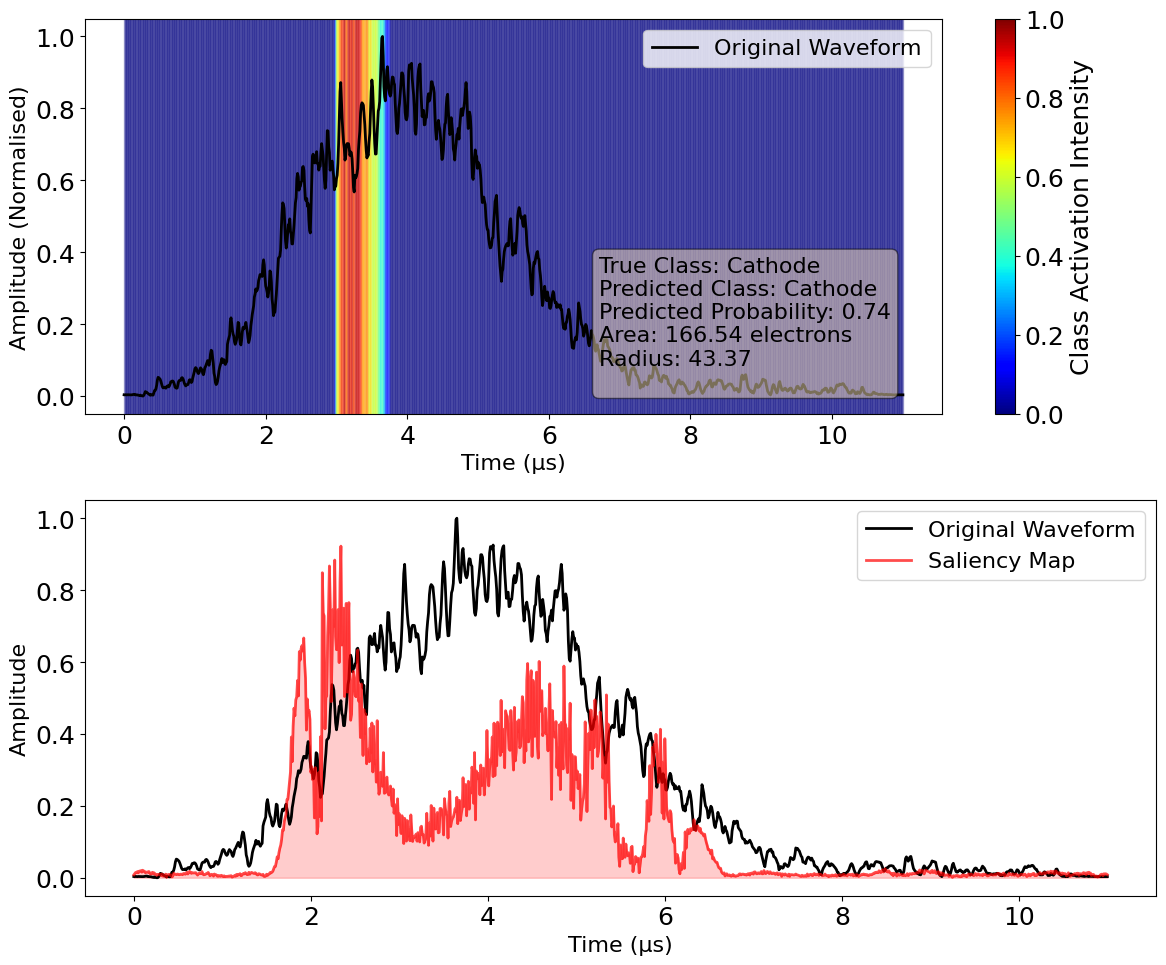

1/1 [==============================] - 0s 17ms/step


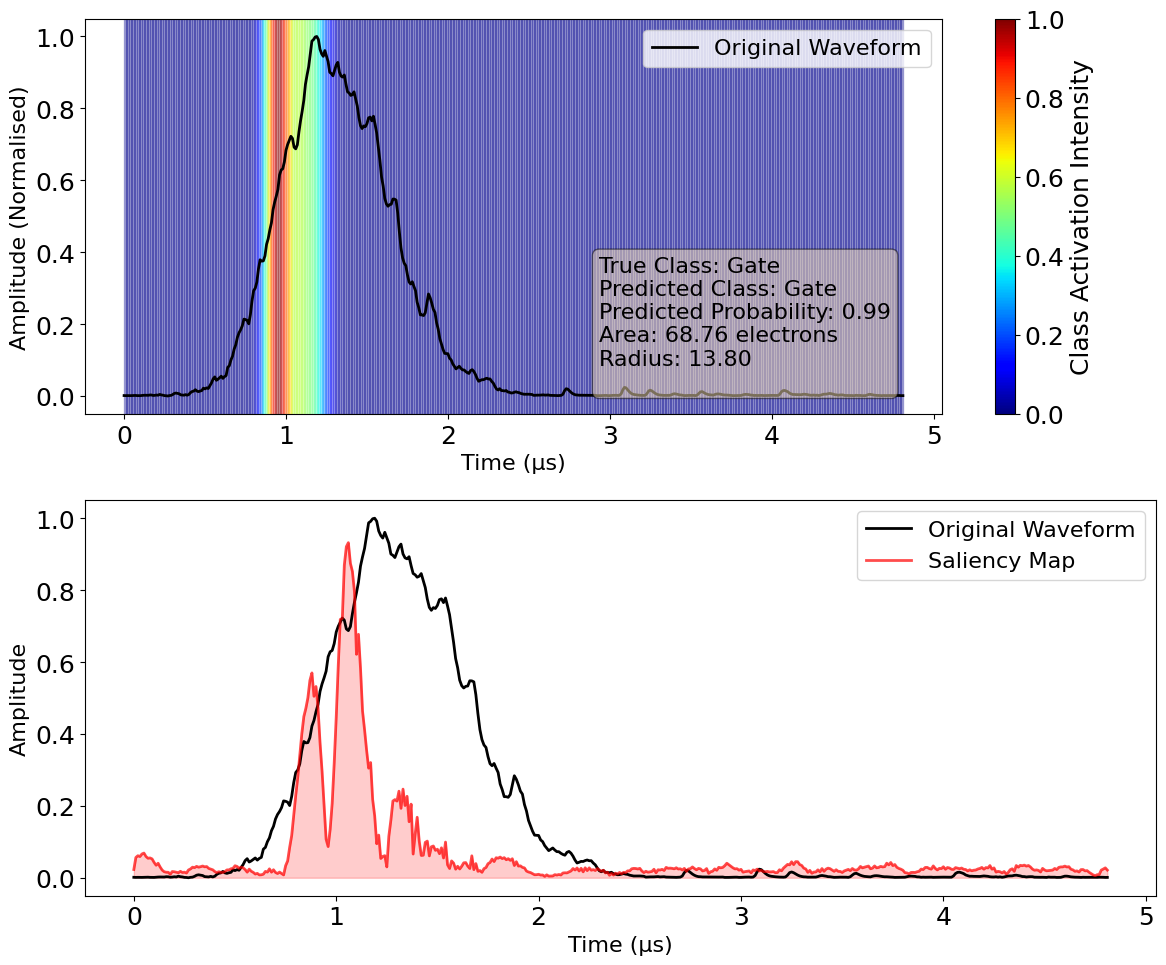

1/1 [==============================] - 0s 39ms/step


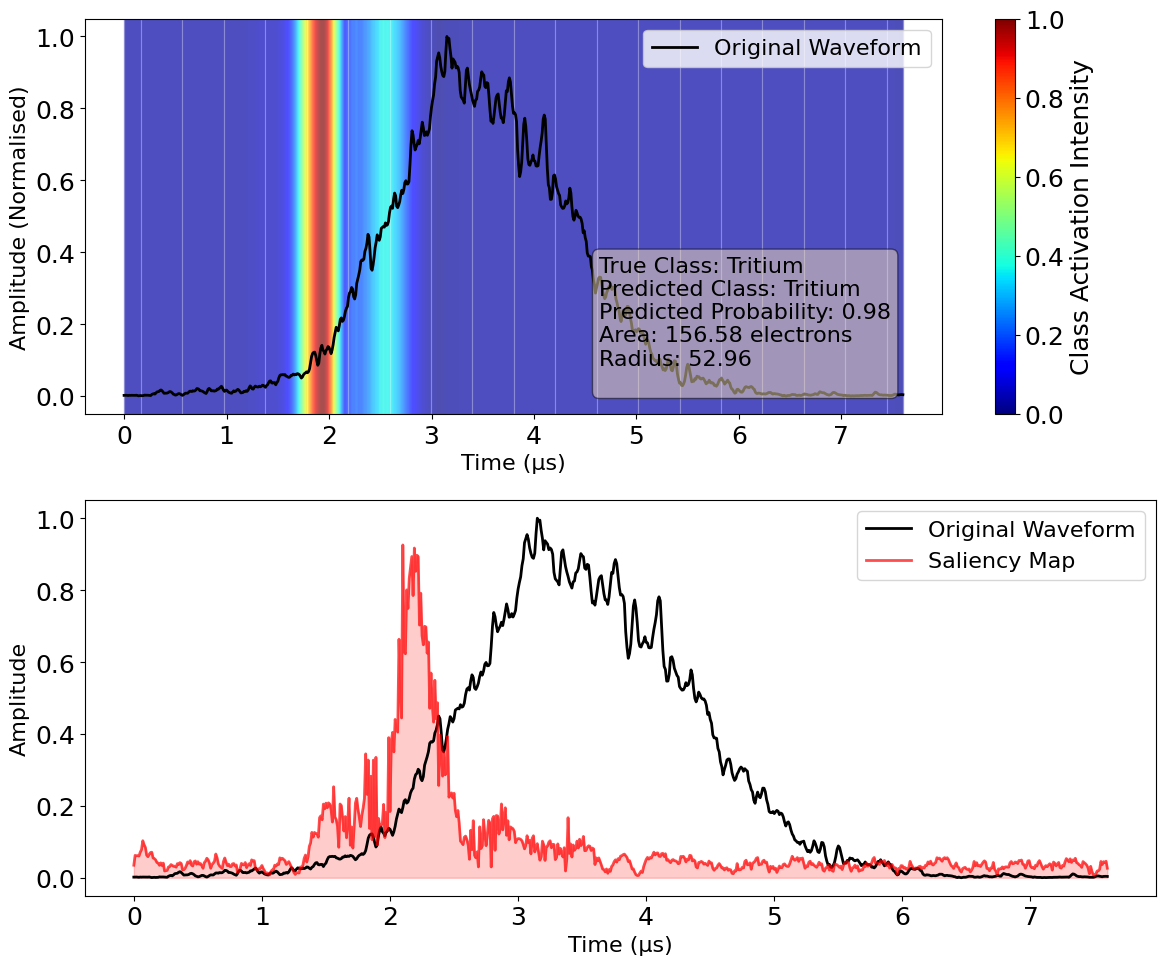

MAX CATHODE INDEX 0
Making predictions on test data...


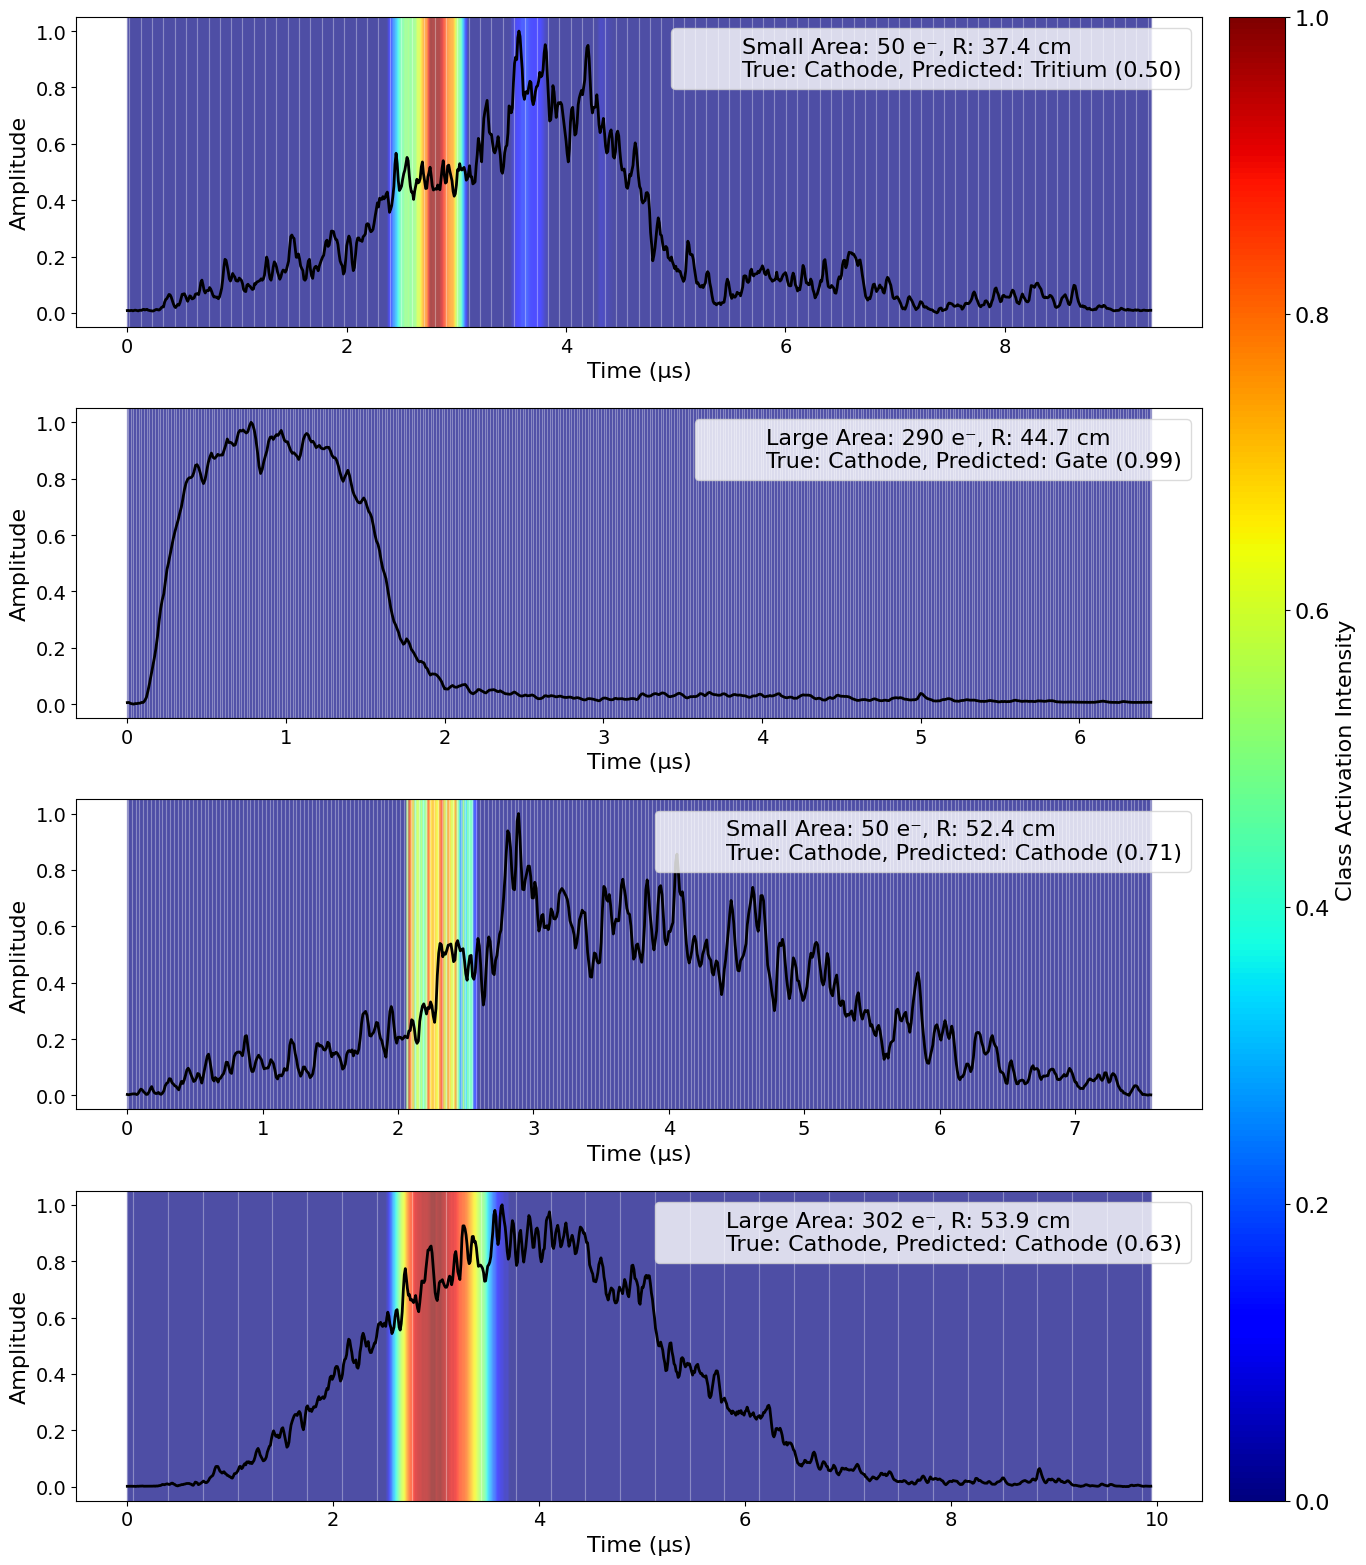

 2/34 [>.............................] - ETA: 2s

KeyboardInterrupt: 

In [ ]:
# 1. Visualise representative examples of each class (choose indices from your test set)
cathode_idx = np.where(y_test == 0)[0][10]  # Cathode event
gate_idx = np.where(y_test == 1)[0][10]     # Gate event
tritium_idx = np.where(y_test == 2)[0][10]  # Tritium event

# print(times_us_test[cathode_idx])
# w = normalised_samples_test[cathode_idx]
# print(w)
# print(type(w))
print(len(normalised_samples_test[cathode_idx]))

# Visualise an example of each of the event-type waveforms with both Grad-CAM and Saliency Maps (Guided backpropagation)
visualise_waveform_with_gradient_analysis(
    cathode_idx, 
    times_us_test[cathode_idx], 
    convoNN, 
    0, 
    area=area_test[cathode_idx], 
    radius=r_test[cathode_idx]
)

visualise_waveform_with_gradient_analysis(
    gate_idx,
    times_us_test[gate_idx], 
    convoNN, 
    1, 
    area=area_test[gate_idx], 
    radius=r_test[gate_idx]
)

visualise_waveform_with_gradient_analysis(
    tritium_idx,
    times_us_test[tritium_idx], 
    convoNN, 
    2, 
    area=area_test[tritium_idx], 
    radius=r_test[tritium_idx]
)

# 2. Compare small-area vs large-area events for each class
# Find small and large area events for each class
cathode_indices = np.where(y_test == 0)[0]
cathode_areas = area_test[cathode_indices]
small_cathode_idx = cathode_indices[np.argmin(cathode_areas)]
large_cathode_idx = cathode_indices[np.argmax(cathode_areas)]

gate_indices = np.where(y_test == 1)[0]
gate_areas = area_test[gate_indices]
small_gate_idx = gate_indices[np.argmin(gate_areas)]
large_gate_idx = gate_indices[np.argmax(gate_areas)]

tritium_indices = np.where(y_test == 2)[0]
tritium_areas = area_test[tritium_indices]
small_tritium_idx = tritium_indices[np.argmin(tritium_areas)]
large_tritium_idx = tritium_indices[np.argmax(tritium_areas)]


visualise_class_comparison(
    model=convoNN,
    X_test_padded=X_test_padded,
    y_test=y_test,
    times_us_test=times_us_test,
    normalised_samples_test=normalised_samples_test,
    area_test=area_test,
    r_test=r_test,
    target_class=0  # 0 for Cathode, 1 for Gate, 2 for Tritium
 )

# Repeat for gate and tritium events

# 3. Analyze any misclassified examples
misclassified = np.where(np.argmax(convoNN.predict(X_test_padded), axis=1) != y_test)[0]
if len(misclassified) > 0:
    misclass_idx = misclassified[0]
    visualise_waveform_with_gradient_analysis(
        sample_index=misclass_idx,
        time_axis=times_us_test[misclass_idx],
        model=convoNN, 
        class_idx=y_test[misclass_idx],
        area=area_test[misclass_idx], 
        radius=r_test[misclass_idx]
    )

# 4. Visualise what patterns specific filters are looking for
# Get the first convolution layer name
conv_layers = [layer for layer in convoNN.layers if isinstance(layer, keras.layers.Conv1D)]
first_conv_layer = conv_layers[0].name

Visualizing the same 5 cathode waveforms with undersampled model:

Cathode sample 1: Normal model confidence = 0.9309, Undersampled model confidence = 0.9690
Waveform shape: (1, 2828, 1), Time axis shape: (1101,)
1/1 [==============================] - 0s 26ms/step


/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_74411/1422135246.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=16)


Figure saved as undersampled_model_cathode_642.png


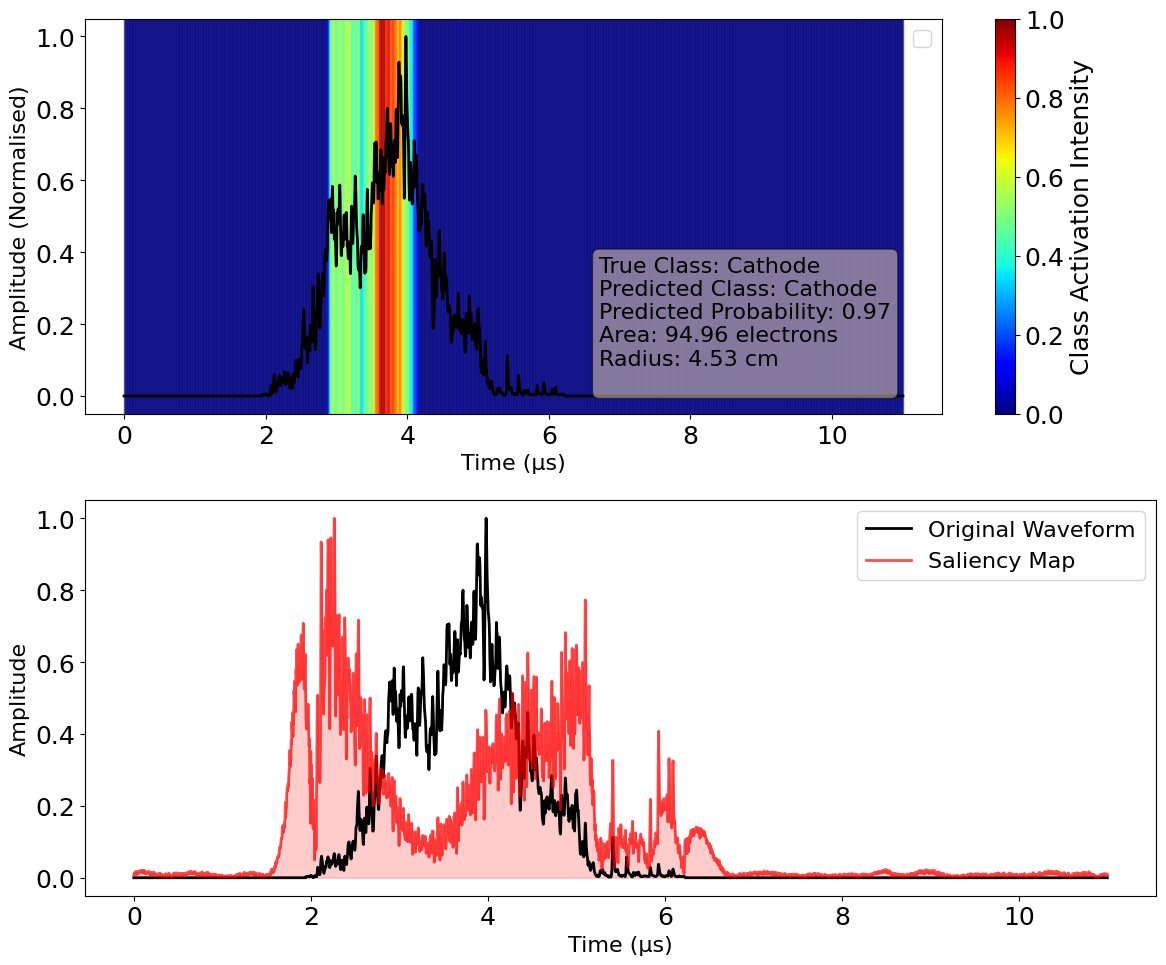


Cathode sample 2: Normal model confidence = 0.9358, Undersampled model confidence = 0.9295
Waveform shape: (1, 2828, 1), Time axis shape: (1123,)
1/1 [==============================] - 0s 17ms/step
Figure saved as undersampled_model_cathode_642.png


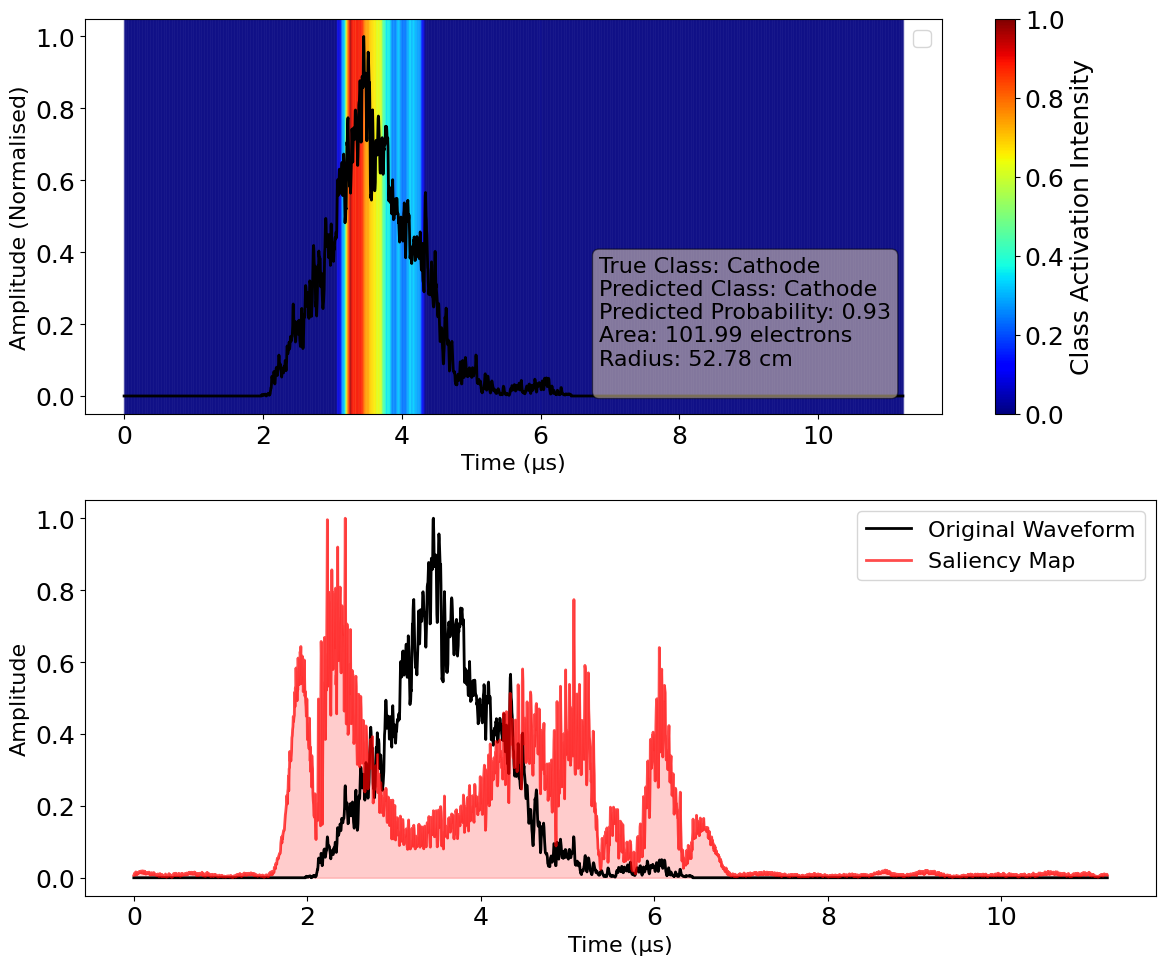


Cathode sample 3: Normal model confidence = 0.9367, Undersampled model confidence = 0.9284
Waveform shape: (1, 2828, 1), Time axis shape: (960,)
1/1 [==============================] - 0s 16ms/step
Figure saved as undersampled_model_cathode_642.png


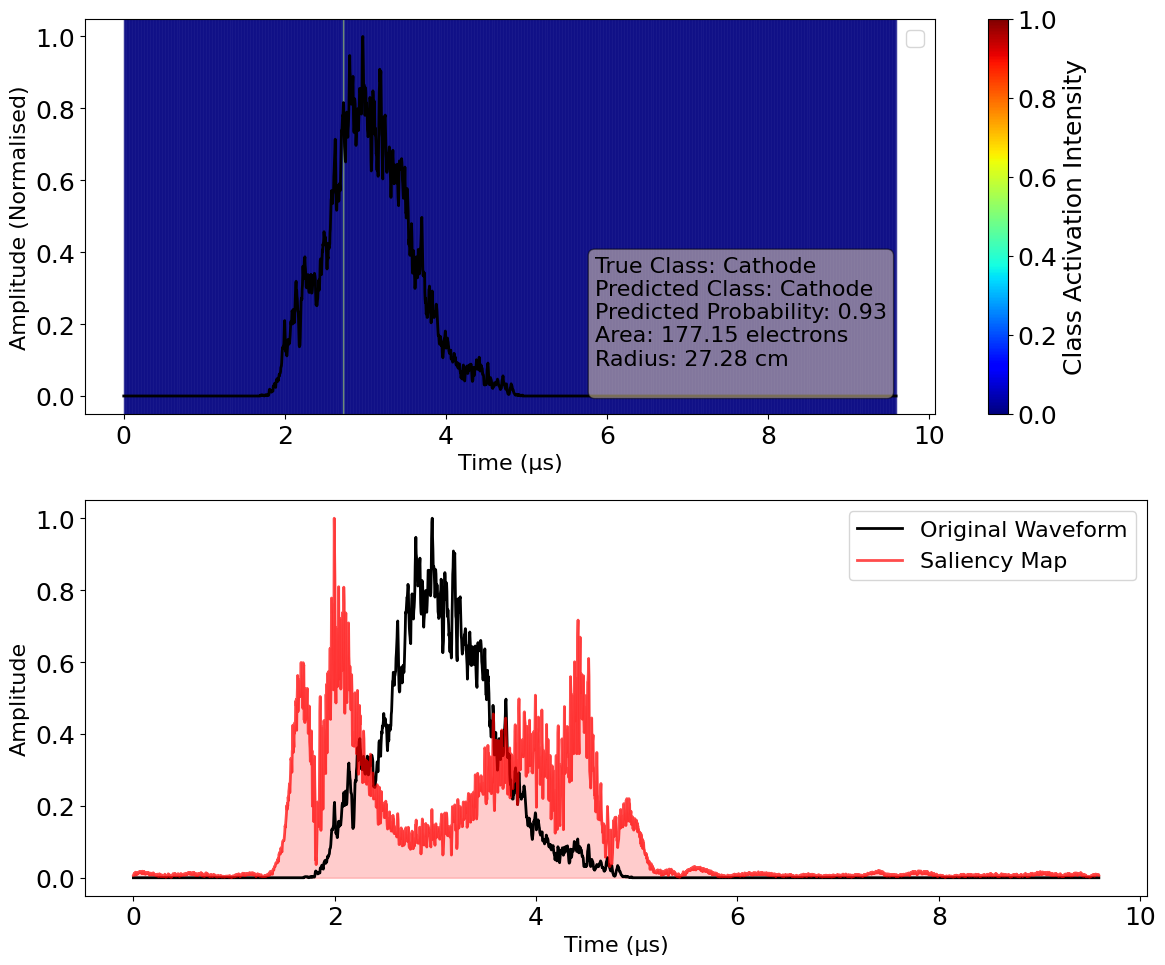


Cathode sample 4: Normal model confidence = 0.9542, Undersampled model confidence = 0.9535
Waveform shape: (1, 2828, 1), Time axis shape: (1035,)
1/1 [==============================] - 0s 14ms/step
Figure saved as undersampled_model_cathode_642.png


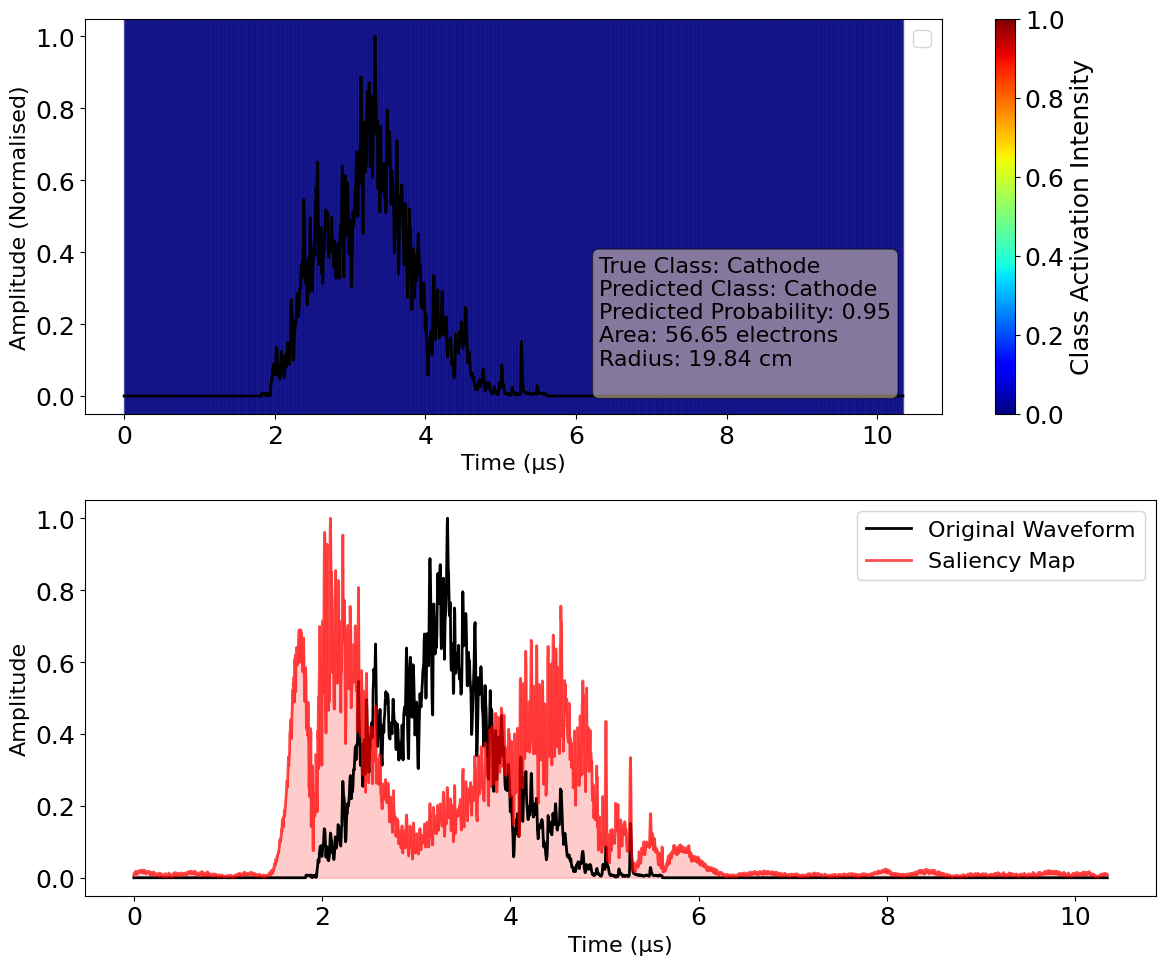


Cathode sample 5: Normal model confidence = 0.9696, Undersampled model confidence = 0.9697
Waveform shape: (1, 2828, 1), Time axis shape: (1033,)
1/1 [==============================] - 0s 16ms/step
Figure saved as undersampled_model_cathode_642.png


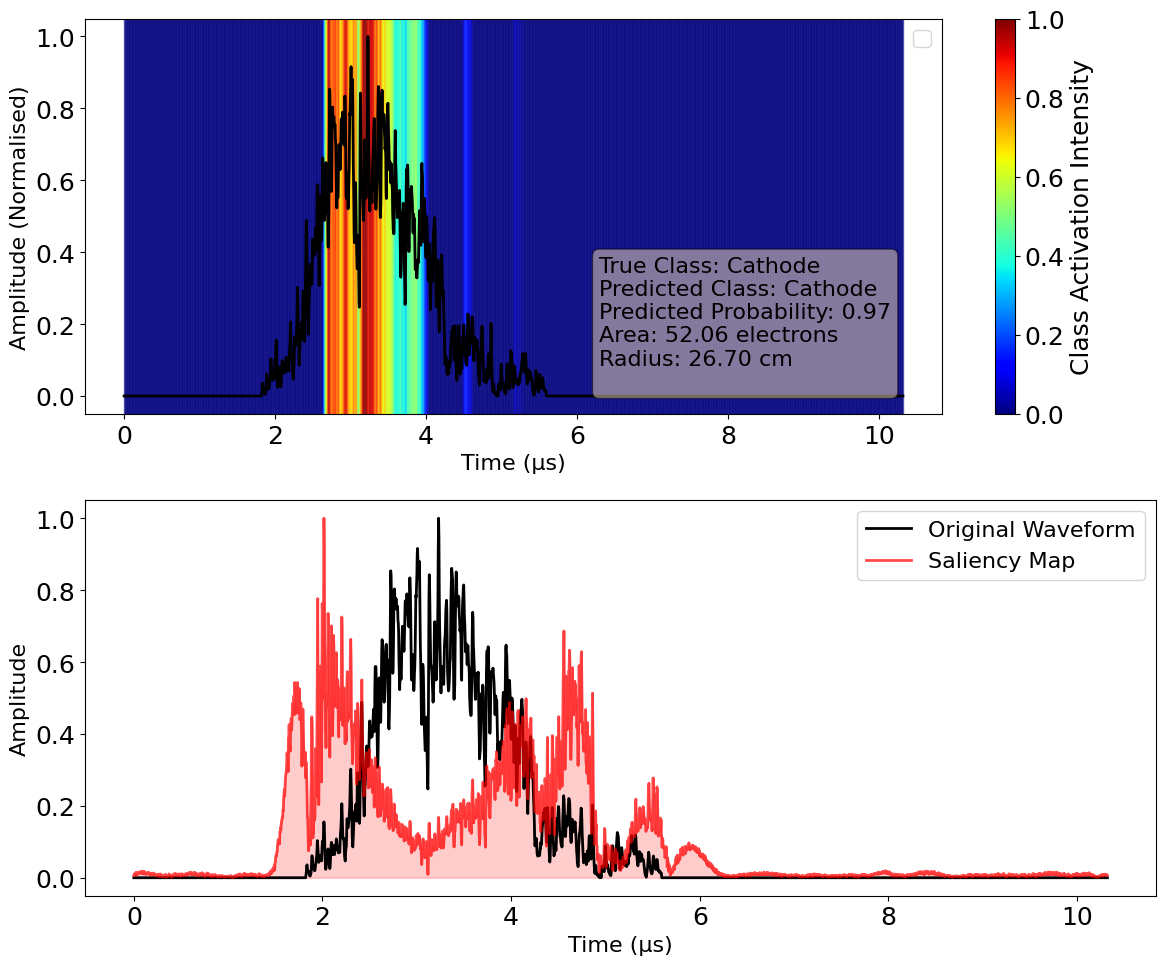

In [161]:
# Load the waveform data saved by the normal model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import tensorflow as tf

with open('top_cathode_waveforms.pkl', 'rb') as f:
    top_waveforms = pickle.load(f)

# Define the custom visualization function that takes waveform directly
def visualise_waveform_with_gradient_analysis_custom(
    waveform_input, time_axis, model, class_idx, class_names=None, 
    area=None, radius=None, use_gradcam=True, use_guided_backprop=True
):
    """
    Modified version of visualization function that takes waveform input directly
    instead of an index.
    """
    if class_names is None:
        class_names = ['Cathode', 'Gate', 'Tritium']

    # Get the waveform data (remove batch and channel dims if needed)
    if len(waveform_input.shape) == 3:
        model_input = waveform_input  # Keep as is for model input
        waveform = waveform_input[0, :, 0]  # Extract for plotting
    else:
        # If just the raw waveform was provided
        waveform = waveform_input
        model_input = waveform_input.reshape(1, -1, 1)
    
    # Get model prediction
    prediction = model.predict(model_input)
    predicted_class = np.argmax(prediction[0])
    prediction_confidence = prediction[0, predicted_class]
    
    # Make sure time_axis and waveform have the same length
    if len(time_axis) != len(waveform):
        print(f"Warning: time_axis ({len(time_axis)}) and waveform ({len(waveform)}) have different lengths.")
        # Resample time_axis to match waveform length
        original_time_range = time_axis[-1] - time_axis[0]
        time_axis = np.linspace(time_axis[0], time_axis[0] + original_time_range, len(waveform))
    
    # Create visualization figure
    fig, axes = plt.subplots(2 if use_gradcam and use_guided_backprop else 1, 
                             1, figsize=(12, 10 if use_gradcam and use_guided_backprop else 6))
    
    if not use_gradcam and not use_guided_backprop:
        ax = axes
    else:
        ax = axes[0] if use_gradcam and use_guided_backprop else axes

    # Plot original waveform
    ax.plot(time_axis, waveform, 'k-', linewidth=2)
    
    # Add info about prediction and sample properties
    info_text = f"True Class: {class_names[class_idx]}\n"
    info_text += f"Predicted Class: {class_names[predicted_class]}\n"
    info_text += f"Predicted Probability: {prediction_confidence:.2f}\n"
    if area is not None:
        info_text += f"Area: {area:.2f} electrons\n"
    if radius is not None:
        info_text += f"Radius: {radius:.2f} cm\n"
    
    # Add a text box with information
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.6, 0.40, info_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    
    if use_gradcam:
        # Calculate Grad-CAM
        heatmap = gradcam_1d(model, model_input, class_idx)
        
        # If the heatmap length doesn't match the waveform, resize it
        if len(heatmap) != len(waveform):
            zoom_factor = len(waveform) / len(heatmap)
            heatmap = zoom(heatmap, zoom_factor)
        
        # Create a colormap for the heatmap
        cmap = plt.cm.jet
        colours = cmap(heatmap)
        
        # Plot the heatmap as a colored background
        for i in range(len(time_axis)-1):
            ax.axvspan(time_axis[i], time_axis[i+1], alpha=0.3, color=colours[i])
        
        # Add a colorbar for the heatmap
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Class Activation Intensity')
    
    ax.set_xlabel('Time (μs)', fontsize=16)
    ax.set_ylabel('Amplitude (Normalised)', fontsize=16)
    ax.legend(loc='upper right', fontsize=16)
    
    if use_guided_backprop:
        if use_gradcam:  # If both visualizations are used
            ax = axes[1]
        
        # Calculate guided backpropagation
        guided_grads = guided_backprop(model, model_input, class_idx)
        
        # Ensure guided_grads has the same length as time_axis
        if len(guided_grads) != len(waveform):
            guided_grads = zoom(guided_grads, len(waveform) / len(guided_grads))
        
        # Get min/max of waveform for scaling
        waveform_min = np.min(waveform)
        waveform_max = np.max(waveform)
        waveform_range = waveform_max - waveform_min
        
        # Scale the normalized gradients to match the waveform's amplitude range
        scaled_guided_grads = guided_grads * waveform_range + waveform_min
        
        # Plot the original waveform
        ax.plot(time_axis, waveform, 'k-', label='Original Waveform', linewidth=2)
        
        # Plot the guided backpropagation as a line
        ax.plot(time_axis, scaled_guided_grads, 'r-', label='Saliency Map', alpha=0.7, linewidth=2)
        
        # Add the filled area below the saliency line
        ax.fill_between(time_axis, waveform_min, scaled_guided_grads, color='r', alpha=0.2)
        
        ax.set_xlabel('Time (μs)', fontsize=16)
        ax.set_ylabel('Amplitude', fontsize=16)
        ax.legend(loc='upper right', fontsize=16)
    
    plt.tight_layout()
    filename = f'undersampled_model_cathode_{sample_index}.png'
    plt.tight_layout()
    plt.savefig(f'/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/{filename}', dpi=1800)
    print(f"Figure saved as {filename}")
    plt.show()

# Now visualize the same waveforms with the undersampled model
print("Visualizing the same 5 cathode waveforms with undersampled model:")
for i, waveform_data in enumerate(top_waveforms):
    # Get the raw waveform input
    if 'raw_waveform' in waveform_data:
        # Check if raw waveform is already in correct shape, otherwise reshape
        if len(waveform_data['raw_waveform'].shape) != 3:
            model_input = waveform_data['raw_waveform'].reshape(1, -1, 1)
        else:
            model_input = waveform_data['raw_waveform']
    else:
        # If no raw_waveform is provided, use the regular waveform
        model_input = waveform_data['waveform'].reshape(1, -1, 1)
    
    # Get prediction from undersampled model
    undersampled_pred = convoNN.predict(model_input, verbose=0)
    undersampled_conf = undersampled_pred[0, 0]  # Cathode class confidence
    
    print(f"\nCathode sample {i+1}: Normal model confidence = {waveform_data['confidence']:.4f}, "
          f"Undersampled model confidence = {undersampled_conf:.4f}")
    
    print(f"Waveform shape: {model_input.shape}, Time axis shape: {waveform_data['time_axis'].shape}")
    
    # Visualize with custom function
    visualise_waveform_with_gradient_analysis_custom(
        model_input, waveform_data['time_axis'], convoNN, 0,
        area=waveform_data['area'], radius=waveform_data['radius']
    )